# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# !pip install modin[dask]

In [2]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
# import modin.pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import math
import random
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.model_selection import StratifiedShuffleSplit
import pickle

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.calibration import CalibratedClassifierCV

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score


import warnings
warnings.filterwarnings("ignore")


sns.set(style="ticks", color_codes=True)

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [3]:
# load in the data
azdias = pd.read_csv('Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('Udacity_CUSTOMERS_052018.csv', sep=';')

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [6]:
print(azdias.shape)
print(customers.shape)
azdias.describe()

(891221, 366)
(191652, 369)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGE

In [7]:
# Read in only the rows with the attribute names
# This serves 2 purposes.. first we get the attribut names... 
# Also, if one of the values is unknown... then, it is present as part of the first row 
# and hence we get that info as well
df_attrs = pd.read_excel('DIAS Attributes - Values 2017.xlsx', skiprows=1)
df_values = df_attrs.copy()
df_attrs.drop(columns=df_attrs.columns[0], inplace=True)
df_attrs.dropna(inplace=True)
df_attrs = df_attrs.reset_index()
print(df_attrs.shape)
df_attrs.head()

(314, 6)


,index,Attribute,Description,Value,Meaning,Type
0,0,AGER_TYP,best-ager typology,-1,unknown,Category
1,5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown,Category
2,11,ALTER_HH,main age within the household,0,unknown / no main age detectable,Numerical
3,33,ANREDE_KZ,gender,"-1, 0",unknown,Category
4,36,ANZ_HAUSHALTE_AKTIV,number of households in the building,…,numeric value (typically coded from 1-10),Numerical


In [8]:
df_values.drop(columns=df_values.columns[0], inplace=True)
df_values.Attribute = df_values.Attribute.fillna(method='ffill')
print(df_values.shape)
df_values.head()

(2258, 5)


,Attribute,Description,Value,Meaning,Type
0,AGER_TYP,best-ager typology,-1,unknown,Category
1,AGER_TYP,NaN,0,no classification possible,NaN
2,AGER_TYP,NaN,1,passive elderly,NaN
3,AGER_TYP,NaN,2,cultural elderly,NaN
4,AGER_TYP,NaN,3,experience-driven elderly,NaN


* Note that above, we have introduced a new column called Type. We have marked all Attributes that ***doesn't*** seem like something that could be measured as a number, as a category.

### Preprocessing

In [9]:
# look at the difference between the data dictionary and the general population dataset
common_columns = (set(list(df_attrs.Attribute)) & set(list(azdias.columns)))
common_columns

{'AGER_TYP',
 'ALTERSKATEGORIE_GROB',
 'ALTER_HH',
 'ANREDE_KZ',
 'ANZ_HAUSHALTE_AKTIV',
 'ANZ_HH_TITEL',
 'ANZ_PERSONEN',
 'ANZ_TITEL',
 'BALLRAUM',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015',
 'CJT_GESAMTTYP',
 'D19_BANKEN_ANZ_12',
 'D19_BANKEN_ANZ_24',
 'D19_BANKEN_DATUM',
 'D19_BANKEN_OFFLINE_DATUM',
 'D19_BANKEN_ONLINE_DATUM',
 'D19_BANKEN_ONLINE_QUOTE_12',
 'D19_GESAMT_ANZ_12',
 'D19_GESAMT_ANZ_24',
 'D19_GESAMT_DATUM',
 'D19_GESAMT_OFFLINE_DATUM',
 'D19_GESAMT_ONLINE_DATUM',
 'D19_GESAMT_ONLINE_QUOTE_12',
 'D19_KONSUMTYP',
 'D19_TELKO_ANZ_12',
 'D19_TELKO_ANZ_24',
 'D19_TELKO_DATUM',
 'D19_TELKO_OFFLINE_DATUM',
 'D19_TELKO_ONLINE_DATUM',
 'D19_VERSAND_ANZ_12',
 'D19_VERSAND_ANZ_24',
 'D19_VERSAND_DATUM',
 'D19_VERSAND_OFFLINE_DATUM',
 'D19_VERSAND_ONLINE_DATUM',
 'D19_VERSAND_ONLINE_QUOTE_12',
 'D19_VERSI_ANZ_12',
 'D19_VERSI_ANZ_24',
 'EWDICHTE',
 'FINANZTYP',
 'FINANZ_ANLEGER',
 'FINANZ_HAUSBAUER',
 'FINANZ_MINIMALIST',
 'FINANZ_SPARER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_VORSORGER

In [29]:
# columns in the dataset that is not present in the data dictionary
diff1 = (set(list(azdias.columns))  - set(list(df_attrs.Attribute)))
print('diff: {}, columns: {}'.format(len(diff1), diff1))
print('--------------------------------------------------')
# columns im the data dictionary that are not present in the dataset
diff2 = (set(list(df_attrs.Attribute)) - set(list(azdias.columns)))
print('diff: {}, columns: {}'.format(len(diff2), diff2))

diff: 94, columns: {'D19_VERSI_ONLINE_QUOTE_12', 'UNGLEICHENN_FLAG', 'D19_TECHNIK', 'RT_UEBERGROESSE', 'D19_BILDUNG', 'D19_HAUS_DEKO', 'RT_KEIN_ANREIZ', 'D19_BANKEN_DIREKT', 'D19_HANDWERK', 'ALTER_KIND1', 'KONSUMZELLE', 'D19_KINDERARTIKEL', 'ANZ_STATISTISCHE_HAUSHALTE', 'VHN', 'D19_DROGERIEARTIKEL', 'D19_VERSI_DATUM', 'KBA13_ANTG2', 'D19_ENERGIE', 'KBA13_GBZ', 'DSL_FLAG', 'D19_DIGIT_SERV', 'CJT_TYP_2', 'STRUKTURTYP', 'MOBI_RASTER', 'D19_SAMMELARTIKEL', 'D19_KOSMETIK', 'EXTSEL992', 'LNR', 'CJT_TYP_3', 'KBA13_CCM_1401_2500', 'KBA13_HHZ', 'KBA13_BAUMAX', 'KBA13_ANTG3', 'ARBEIT', 'D19_REISEN', 'CJT_TYP_6', 'D19_BEKLEIDUNG_GEH', 'ALTER_KIND2', 'D19_SOZIALES', 'D19_VERSICHERUNGEN', 'D19_BEKLEIDUNG_REST', 'D19_VERSI_OFFLINE_DATUM', 'VERDICHTUNGSRAUM', 'D19_SCHUHE', 'D19_LEBENSMITTEL', 'ALTER_KIND4', 'D19_LOTTO', 'D19_SONSTIGE', 'AKT_DAT_KL', 'D19_TELKO_REST', 'D19_BANKEN_GROSS', 'KBA13_ANTG4', 'VK_DISTANZ', 'UMFELD_ALT', 'D19_TIERARTIKEL', 'D19_KONSUMTYP_MAX', 'D19_NAHRUNGSERGAENZUNG', 'EINGE

In [31]:
# many columns in data dictionary have a prefix of RZ.. let's see if we take that into account... what happens
rz_removed = [col.strip('_RZ') for col in list(diff2)]
diff3 = (set(rz_removed) - set(list(azdias.columns)))
print('diff: {}, columns: {}'.format(len(diff3), diff3))
print('-----------')
print(list(rz_removed))

diff: 10, columns: {'BIP_FLAG', 'D19_BUCH', 'HAUSHALTSSTRUKTU', 'WACHSTUMSGEBIET_NB', 'GEOSCORE_KLS7', 'CAMEO_DEUINTL_2015', 'KBA13_CCM_1400_2500', 'D19_RATGEBE', 'D19_KK_KUNDENTYP', 'SOHO_FLAG'}
-----------
['BIP_FLAG', 'D19_TIERARTIKEL', 'D19_REISEN', 'D19_BEKLEIDUNG_GEH', 'D19_BANKEN_DIREKT', 'D19_NAHRUNGSERGAENZUNG', 'D19_ENERGIE', 'D19_KOSMETIK', 'HAUSHALTSSTRUKTU', 'CAMEO_DEUINTL_2015', 'D19_KINDERARTIKEL', 'D19_DIGIT_SERV', 'D19_DROGERIEARTIKEL', 'D19_VERSICHERUNGEN', 'D19_TELKO_MOBILE', 'D19_BANKEN_GROSS', 'D19_TECHNIK', 'D19_SAMMELARTIKEL', 'D19_TELKO_REST', 'D19_FREIZEIT', 'D19_BILDUNG', 'D19_HANDWERK', 'D19_HAUS_DEKO', 'D19_SONSTIGE', 'WACHSTUMSGEBIET_NB', 'GEOSCORE_KLS7', 'D19_WEIN_FEINKOST', 'D19_BANKEN_LOKAL', 'D19_RATGEBE', 'D19_SCHUHE', 'D19_BEKLEIDUNG_REST', 'D19_BUCH', 'D19_KK_KUNDENTYP', 'D19_GARTEN', 'D19_VOLLSORTIMENT', 'D19_VERSAND_REST', 'KBA13_CCM_1400_2500', 'D19_BIO_OEKO', 'D19_LEBENSMITTEL', 'D19_LOTTO', 'SOHO_FLAG', 'D19_BANKEN_REST']


In [33]:
modified_attr_cols = set(list(df_attrs.Attribute)).union( set(rz_removed))
# print(modified_attr_cols)
# print('----------')
extra_columns = (set(list(azdias.columns)) - set(modified_attr_cols))
print('diff: {}, columns: {}'.format(len(extra_columns), extra_columns))

diff: 62, columns: {'KK_KUNDENTYP', 'D19_VERSI_ONLINE_QUOTE_12', 'AKT_DAT_KL', 'EXTSEL992', 'RT_UEBERGROESSE', 'KBA13_ANTG4', 'LNR', 'VK_DISTANZ', 'CJT_TYP_3', 'UMFELD_ALT', 'RT_KEIN_ANREIZ', 'ALTER_KIND1', 'D19_KONSUMTYP_MAX', 'GEMEINDETYP', 'EINGEZOGENAM_HH_JAHR', 'KONSUMZELLE', 'CJT_TYP_5', 'D19_RATGEBER', 'KBA13_CCM_1401_2500', 'KBA13_HHZ', 'KBA13_ANTG3', 'KBA13_BAUMAX', 'ARBEIT', 'CJT_TYP_6', 'ANZ_STATISTISCHE_HAUSHALTE', 'VHN', 'D19_TELKO_ONLINE_QUOTE_12', 'CAMEO_INTL_2015', 'D19_VERSI_DATUM', 'CJT_TYP_4', 'KBA13_ANTG2', 'D19_VERSI_ONLINE_DATUM', 'D19_LETZTER_KAUF_BRANCHE', 'HH_DELTA_FLAG', 'ALTER_KIND2', 'VK_DHT4A', 'D19_SOZIALES', 'CJT_KATALOGNUTZER', 'SOHO_KZ', 'ALTERSKATEGORIE_FEIN', 'KBA13_ANTG1', 'ALTER_KIND3', 'D19_VERSI_OFFLINE_DATUM', 'KBA13_GBZ', 'VERDICHTUNGSRAUM', 'DSL_FLAG', 'VK_ZG11', 'CJT_TYP_2', 'CJT_TYP_1', 'ANZ_KINDER', 'KOMBIALTER', 'EINGEFUEGT_AM', 'D19_BUCH_CD', 'UMFELD_JUNG', 'RT_SCHNAEPPCHEN', 'STRUKTURTYP', 'MOBI_RASTER', 'KBA13_KMH_210', 'FIRMENDICHTE', '

In [79]:
for col in rz_removed:
    original = col + '_RZ'
    df_attrs['Attribute'].replace(original, col, inplace=True)
    df_values['Attribute'].replace(original, col, inplace=True)

In [47]:
def get_missing_values(df):
    missing_dict = dict()
    missing_indicators = [
        'unknown',
        'no transaction known',
        'no transactions known',
        '',
    ]
    for i in df.index:
        if df['Meaning'][i] in missing_indicators:
#             print('column : {} has missing values : {}'.format( df['Attribute'][i], df['Value'][i]))
            missing_dict[df['Attribute'][i]] = df['Value'][i]
    return missing_dict

In [61]:
missing_values_dict = get_missing_values(df_values)
missing_values_dict

{'AGER_TYP': -1,
 'ALTERSKATEGORIE_GROB': '-1, 0',
 'ANREDE_KZ': '-1, 0',
 'BALLRAUM': -1,
 'BIP_FLAG': -1,
 'CAMEO_DEUG_2015': -1,
 'CAMEO_DEUINTL_2015': -1,
 'CJT_GESAMTTYP': 0,
 'D19_BANKEN_ANZ_12': 0,
 'D19_BANKEN_ANZ_24': 0,
 'D19_BANKEN_DATUM': 10,
 'D19_BANKEN_DIREKT_RZ': 0,
 'D19_BANKEN_GROSS_RZ': 0,
 'D19_BANKEN_LOKAL_RZ': 0,
 'D19_BANKEN_OFFLINE_DATUM': 10,
 'D19_BANKEN_ONLINE_DATUM': 10,
 'D19_BANKEN_REST_RZ': 0,
 'D19_BEKLEIDUNG_GEH_RZ': 0,
 'D19_BEKLEIDUNG_REST_RZ': 0,
 'D19_BILDUNG_RZ': 0,
 'D19_BIO_OEKO_RZ': 0,
 'D19_BUCH_RZ': 0,
 'D19_DIGIT_SERV_RZ': 0,
 'D19_DROGERIEARTIKEL_RZ': 0,
 'D19_ENERGIE_RZ': 0,
 'D19_FREIZEIT_RZ': 0,
 'D19_GARTEN_RZ': 0,
 'D19_GESAMT_ANZ_12': 0,
 'D19_GESAMT_ANZ_24': 0,
 'D19_GESAMT_DATUM': 10,
 'D19_GESAMT_OFFLINE_DATUM': 10,
 'D19_GESAMT_ONLINE_DATUM': 10,
 'D19_HANDWERK_RZ': 0,
 'D19_HAUS_DEKO_RZ': 0,
 'D19_KINDERARTIKEL_RZ': 0,
 'D19_KK_KUNDENTYP': -1,
 'D19_KOSMETIK_RZ': 0,
 'D19_LEBENSMITTEL_RZ': 0,
 'D19_LOTTO_RZ': 0,
 'D19_NAHRUNGSERGA

In [68]:
def mark_missing_values_as_null(df, missing_values_dict):
    for col in df.columns:
#       if the column exists in the data dictionary
        if col in missing_values_dict.keys():
            unknown_values =  list(map(int, str(missing_values_dict[col]).strip().split(',')))
            df.loc[df[col].isin(unknown_values), col] = np.NaN
            print(unknown_values)
    return df

In [69]:
azdias = mark_missing_values_as_null(azdias, missing_values_dict)

[-1]
[-1]
[-1]
[0]
[0]
[0]
[10]
[10]
[10]
[0]
[0]
[10]
[10]
[10]
[0]
[0]
[10]
[10]
[10]
[0]
[0]
[10]
[10]
[10]
[0]
[0]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1, 0]
[-1]
[-1, 0]
[-1]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1]
[-1]
[-1]
[-1]
[-1, 9]
[-1, 0]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 0]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1, 9]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-1]
[-

In [70]:
# There are a few values like X and XX specific to a few columns that also represent missing values.. let's add that to the dictionary
cols = 'CAMEO_INTL_2015,CAMEO_DEUG_2015,CAMEO_DEU_2015'.split(',')
for col in cols:
    azdias[col].replace('X', np.NaN, inplace=True)
    azdias[col].replace('XX', np.NaN, inplace=True)

In [71]:
def plot_hist_missing_col(df):
    '''
    INPUT:
        df - (dataframe), dataframe to check for missing data and plot histogram of the missing data in columns
    OUTPUT:
        visualization: (histogram), of the missing data
    '''
    plt.hist(df['pct'], bins=20, facecolor='g', alpha=0.75)

    plt.xlabel('Pe\rcentage of missing value (%)', fontsize=12)
    plt.ylabel('Counts', fontsize=12)
    plt.title('Histogram of missing value counts in columns', fontsize=12)
    plt.grid(True)
    plt.show()


def get_null_counts(df):
    null_data = df.isnull().sum()[df.isnull().sum() > 0]
    dict = {'nulls': null_data.values, 'pct': np.round(null_data.values*100/df.shape[0], 2)}
    df_nulls = pd.DataFrame(data=dict, index=null_data.index)
    return df_nulls

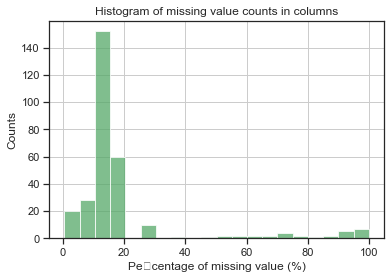

,nulls,pct
ALTER_KIND4,890016,99.86
TITEL_KZ,889061,99.76
ALTER_KIND3,885051,99.31
D19_TELKO_ONLINE_DATUM,883018,99.08
D19_BANKEN_OFFLINE_DATUM,871535,97.79
ALTER_KIND2,861722,96.69
D19_TELKO_ANZ_12,857990,96.27
D19_BANKEN_ANZ_12,831734,93.33
D19_TELKO_ANZ_24,826208,92.71
D19_VERSI_ANZ_12,821289,92.15


In [74]:
# let's look at the distribution of nulls
azdias_nulls = get_null_counts(azdias)
plot_hist_missing_col(azdias_nulls)
azdias_nulls.sort_values(by=['pct'], axis=0, kind='quicksort', ascending=False, inplace=True)
azdias_nulls

In [78]:
print(azdias_nulls[azdias_nulls.pct > 30])

                            nulls    pct
ALTER_KIND4                890016  99.86
TITEL_KZ                   889061  99.76
ALTER_KIND3                885051  99.31
D19_TELKO_ONLINE_DATUM     883018  99.08
D19_BANKEN_OFFLINE_DATUM   871535  97.79
ALTER_KIND2                861722  96.69
D19_TELKO_ANZ_12           857990  96.27
D19_BANKEN_ANZ_12          831734  93.33
D19_TELKO_ANZ_24           826208  92.71
D19_VERSI_ANZ_12           821289  92.15
D19_TELKO_OFFLINE_DATUM    819114  91.91
ALTER_KIND1                810163  90.90
D19_BANKEN_ANZ_24          794100  89.10
D19_VERSI_ANZ_24           777037  87.19
D19_BANKEN_ONLINE_DATUM    726982  81.57
D19_BANKEN_DATUM           678331  76.11
AGER_TYP                   677503  76.02
D19_TELKO_DATUM            665798  74.71
EXTSEL992                  654153  73.40
D19_VERSAND_ANZ_12         637972  71.58
D19_VERSAND_OFFLINE_DATUM  634233  71.16
D19_GESAMT_ANZ_12          584797  65.62
KK_KUNDENTYP               584612  65.60
D19_VERSAND_ANZ_

In [86]:
# replace the values representing unknown with NaN
def mark_invalid_values_as_null(df):
    for colname in common_columns:
        print(df_attrs[df_attrs.Attribute==colname].Type.values[0])
        valid_values = df_values[(df_values.Attribute==colname) & (df_values.Meaning.str.contains('unknown')==False)].Value.values
        print('valid values for column:{}, are {}'.format(colname, valid_values))
        print(colname)
        m = df[colname].isin(valid_values)
        df[colname] = df[colname].where(m, other=np.nan)
        print(sum(m))
        if df_attrs[df_attrs.Attribute==colname].Type.values[0] == 'Category': 
#           converting from int to float rather than from float to int, as type conversion with NaNs
#           doesn't work when converting to ints
            print('Category data type={}'.format(df.dtypes[colname]))
            if df.dtypes[colname]=='float64':
                df[colname] = df[colname].astype(pd.Int16Dtype())
                
            # make this column as categorical, so that get_dummies works consistently
            print('unqiue cat values in the DF are: {}'.format(df[colname].unique()))
    return df, categorical_dict

# The below method is no longer required... as we are marking the unknowns as nan in tge above function
# def mark_unknown_as_null(df):
#     for colname in common_columns:
#         if df_attrs[df_attrs.Attribute==colname].Meaning.values[0].find('unknown') > -1:
#             unknown_values = str(df_attrs[df_attrs.Attribute==colname].Value.values[0])
#             unknown_values = list(map(int, unknown_values.strip().split(','))) 
#             df.loc[df[colname].isin(unknown_values), colname] = np.NaN
#     return df

In [87]:
df_values[(df_values.Attribute=='TITEL_KZ') & (df_values.Meaning.str.contains('unknown')==False)].Value.values

array([1, 2, 3, 4, 5], dtype=object)

In [88]:
azdias_sel_cols, categorical_dict = mark_invalid_values_as_null(azdias_sel_cols)
# azdias_sel_cols = mark_unknown_as_null(azdias_sel_cols)

Numerical
valid values for column:KBA13_KRSSEG_VAN, are [0 1 2 3]
KBA13_KRSSEG_VAN
785421
Numerical
valid values for column:SEMIO_LUST, are [1 2 3 4 5 6 7]
SEMIO_LUST
891221
Numerical
valid values for column:KBA05_HERSTTEMP, are [1 2 3 4 5]
KBA05_HERSTTEMP
781184
Category
valid values for column:CAMEO_DEUG_2015, are [1 2 3 4 5 6 7 8 9]
CAMEO_DEUG_2015
332884
Category data type=object
unqiue cat values in the DF are: [nan 8.0 4.0 2.0 6.0 1.0 9.0 5.0 7.0 3.0]
Numerical
valid values for column:KBA13_FIAT, are [0 1 2 3 4 5]
KBA13_FIAT
785421
Numerical
valid values for column:KBA13_CCM_1400, are [0 1 2 3 4 5]
KBA13_CCM_1400
785421
Numerical
valid values for column:KBA05_ALTER2, are [1 2 3 4 5]
KBA05_ALTER2
743111
Numerical
valid values for column:KBA13_HALTER_65, are [0 1 2 3 4 5]
KBA13_HALTER_65
785421
Numerical
valid values for column:KBA13_VORB_2, are [0 1 2 3 4 5]
KBA13_VORB_2
785421
Numerical
valid values for column:KBA13_NISSAN, are [0 1 2 3 4 5]
KBA13_NISSAN
785421
Category
valid val

unqiue cat values in the DF are: <IntegerArray>
[<NA>, 1, 4, 3, 5, 2]
Length: 6, dtype: Int16
Numerical
valid values for column:KBA13_BJ_2008, are [0 1 2 3 4 5]
KBA13_BJ_2008
785421
Numerical
valid values for column:KBA05_MAXAH, are [1 2 3 4 5]
KBA05_MAXAH
743111
Numerical
valid values for column:KBA13_KMH_140, are [0 1 2 3 4 5]
KBA13_KMH_140
785421
Numerical
valid values for column:KBA13_VORB_3, are [0 1 2 3 4 5]
KBA13_VORB_3
785421
Numerical
valid values for column:KBA13_CCM_1000, are [0 1 2 3 4 5]
KBA13_CCM_1000
785421
Numerical
valid values for column:KBA13_BMW, are [0 1 2 3 4 5]
KBA13_BMW
785421
Numerical
valid values for column:KBA13_KMH_0_140, are [0 1 2 3 4 5]
KBA13_KMH_0_140
785421
Numerical
valid values for column:KBA13_KMH_140_210, are [0 1 2 3 4 5]
KBA13_KMH_140_210
785421
Numerical
valid values for column:KBA13_KW_40, are [0 1 2 3 4 5]
KBA13_KW_40
785421
Numerical
valid values for column:ORTSGR_KLS9, are [1 2 3 4 5 6 7 8 9]
ORTSGR_KLS9
793947
Numerical
valid values for col

743111
Category
valid values for column:D19_BANKEN_ONLINE_DATUM, are [1 2 3 4 5 6 7 8 9 10]
D19_BANKEN_ONLINE_DATUM
891221
Category data type=int64
unqiue cat values in the DF are: [10  5  8  6  9  1  4  7  2  3]
Category
valid values for column:KBA05_MAXVORB, are [1 2 3]
KBA05_MAXVORB
743111
Category data type=float64
unqiue cat values in the DF are: <IntegerArray>
[<NA>, 3, 1, 2]
Length: 4, dtype: Int16
Numerical
valid values for column:KBA05_MOD8, are [0 1 2 3]
KBA05_MOD8
743111
Numerical
valid values for column:KBA13_CCM_1600, are [0 1 2 3 4 5]
KBA13_CCM_1600
785421
Numerical
valid values for column:KBA13_HERST_ASIEN, are [0 1 2 3 4 5]
KBA13_HERST_ASIEN
785421
Numerical
valid values for column:D19_VERSI_ANZ_12, are [0 1 2 3 4 5 6]
D19_VERSI_ANZ_12
891221
Category
valid values for column:D19_GESAMT_DATUM, are [1 2 3 4 5 6 7 8 9 10]
D19_GESAMT_DATUM
891221
Category data type=int64
unqiue cat values in the DF are: [10  1  3  5  9  4  7  6  8  2]
Numerical
valid values for column:SEMIO

785421
Numerical
valid values for column:KBA13_KW_120, are [0 1 2 3 4 5]
KBA13_KW_120
785421
Numerical
valid values for column:ANZ_PERSONEN, are ['…']
ANZ_PERSONEN
0
Category
valid values for column:TITEL_KZ, are [1 2 3 4 5]
TITEL_KZ
2160
Category data type=float64
unqiue cat values in the DF are: <IntegerArray>
[<NA>, 4, 1, 3, 5, 2]
Length: 6, dtype: Int16
Numerical
valid values for column:D19_GESAMT_ANZ_24, are [0 1 2 3 4 5 6]
D19_GESAMT_ANZ_24
891221
Category
valid values for column:D19_TELKO_ONLINE_DATUM, are [1 2 3 4 5 6 7 8 9 10]
D19_TELKO_ONLINE_DATUM
891221
Category data type=int64
unqiue cat values in the DF are: [10  9  7  8  6  5  4  1  2  3]
Numerical
valid values for column:GEBURTSJAHR, are ['…']
GEBURTSJAHR
0
Numerical
valid values for column:D19_VERSAND_ONLINE_QUOTE_12, are [0 1 2 3 4 5 6 7 8 9 10]
D19_VERSAND_ONLINE_QUOTE_12
634108
Numerical
valid values for column:KBA05_KRSAQUOT, are [1 2 3 4 5]
KBA05_KRSAQUOT
743111
Numerical
valid values for column:KBA13_HALTER_20, a

In [89]:
# it is clear from tne above that columns "CAMEO_DEU_2015,LP_LEBENSPHASE_FEIN" contain too many categories
# and hence it might be better to srop them
azdias_sel_cols = azdias_sel_cols.drop(columns=['CAMEO_DEU_2015','LP_LEBENSPHASE_FEIN'])

In [90]:
null_data = azdias_sel_cols.isnull().sum()[azdias_sel_cols.isnull().sum() > 0]
dict = {'nulls': null_data.values, 'pct': np.round(null_data.values*100/azdias_sel_cols.shape[0], 2)}
df_nulls = pd.DataFrame(data=dict, index=null_data.index)
df_nulls.sort_values(by='pct', ascending=False, inplace=True)

In [91]:
def plot_hist_missing_col(df):
    '''
    INPUT:
        df - (dataframe), dataframe to check for missing data and plot histogram of the missing data in columns
    OUTPUT:
        visualization: (histogram), of the missing data
    '''
    plt.hist(df['pct'], bins=20, facecolor='g', alpha=0.75)

    plt.xlabel('Percentage of missing value (%)', fontsize=12)
    plt.ylabel('Counts', fontsize=12)
    plt.title('Histogram of missing value counts in columns', fontsize=12)
    plt.grid(True)
    plt.show()

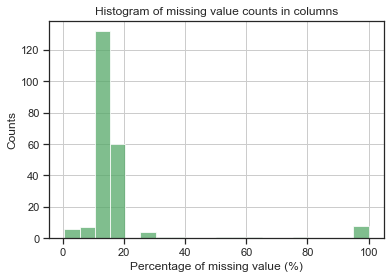

In [92]:
plot_hist_missing_col(df_nulls)

In [93]:
# it is c;ear from the above that most of the data has less than 20% of their values as null.
print(df_nulls[df_nulls.pct > 20])
df_nulls[df_nulls.pct > 20].count()

                              nulls     pct
ANZ_HAUSHALTE_AKTIV          891221  100.00
MIN_GEBAEUDEJAHR             891221  100.00
GEBURTSJAHR                  891221  100.00
ANZ_PERSONEN                 891221  100.00
KBA13_ANZAHL_PKW             891221  100.00
ANZ_HH_TITEL                 891221  100.00
ANZ_TITEL                    891221  100.00
TITEL_KZ                     889061   99.76
AGER_TYP                     677503   76.02
CAMEO_DEUG_2015              558337   62.65
LP_STATUS_GROB               512737   57.53
KBA05_BAUMAX                 476524   53.47
LP_FAMILIE_GROB              331356   37.18
ALTER_HH                     310267   34.81
D19_BANKEN_ONLINE_QUOTE_12   257113   28.85
D19_GESAMT_ONLINE_QUOTE_12   257113   28.85
D19_VERSAND_ONLINE_QUOTE_12  257113   28.85
D19_KONSUMTYP                257113   28.85


nulls    18
pct      18
dtype: int64

In [94]:
# remove the columns from the dataset that have more than 20% of their values as null, one way or the other
azdias_sel_cols.drop(columns=df_nulls[df_nulls.pct>20].index, inplace=True)
final_column_list = azdias_sel_cols.columns

In [95]:
azdias_sel_cols.shape

(891221, 252)

In [96]:
# All the columns that can be treated as a numerical measure of something, we'll use mean value to replace the NaNs
# For Cateforical columns, we'll use mode to replace the NaN values
category_columns = df_attrs[(df_attrs.Type.str.lower()=='category') & 
                            df_attrs.Attribute.isin(final_column_list)
                           ].Attribute.values
numerical_columns = df_attrs[(df_attrs.Type.str.lower()!='category') & 
                             df_attrs.Attribute.isin(final_column_list)].Attribute.values
print(category_columns)
print(numerical_columns)
print(len(category_columns) + len(numerical_columns))
df_attrs.count()

['ANREDE_KZ' 'CJT_GESAMTTYP' 'D19_BANKEN_DATUM' 'D19_BANKEN_OFFLINE_DATUM'
 'D19_BANKEN_ONLINE_DATUM' 'D19_GESAMT_DATUM' 'D19_GESAMT_OFFLINE_DATUM'
 'D19_GESAMT_ONLINE_DATUM' 'D19_TELKO_ANZ_12' 'D19_TELKO_ANZ_24'
 'D19_TELKO_DATUM' 'D19_TELKO_OFFLINE_DATUM' 'D19_TELKO_ONLINE_DATUM'
 'D19_VERSAND_DATUM' 'D19_VERSAND_OFFLINE_DATUM'
 'D19_VERSAND_ONLINE_DATUM' 'FINANZTYP' 'GEBAEUDETYP' 'GEBAEUDETYP_RASTER'
 'GFK_URLAUBERTYP' 'GREEN_AVANTGARDE' 'HEALTH_TYP' 'KBA05_MAXHERST'
 'KBA05_MAXSEG' 'KBA05_MAXVORB' 'KBA05_MODTEMP' 'KBA05_MOTOR'
 'LP_FAMILIE_FEIN' 'LP_LEBENSPHASE_GROB' 'LP_STATUS_FEIN'
 'NATIONALITAET_KZ' 'OST_WEST_KZ' 'PRAEGENDE_JUGENDJAHRE' 'RETOURTYP_BK_S'
 'SHOPPER_TYP' 'VERS_TYP' 'ZABEOTYP']
['ALTERSKATEGORIE_GROB' 'BALLRAUM' 'D19_BANKEN_ANZ_12' 'D19_BANKEN_ANZ_24'
 'D19_GESAMT_ANZ_12' 'D19_GESAMT_ANZ_24' 'D19_VERSAND_ANZ_12'
 'D19_VERSAND_ANZ_24' 'D19_VERSI_ANZ_12' 'D19_VERSI_ANZ_24' 'EWDICHTE'
 'FINANZ_ANLEGER' 'FINANZ_HAUSBAUER' 'FINANZ_MINIMALIST' 'FINANZ_SPARER'
 'FINANZ_UN

index          314
Attribute      314
Description    314
Value          314
Meaning        314
Type           314
dtype: int64

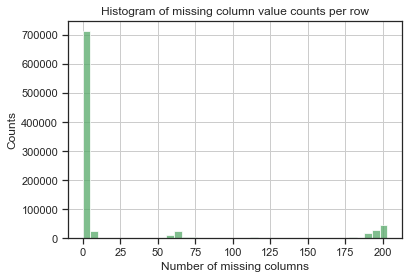

In [97]:
null_row_counts = azdias_sel_cols.isnull().sum(axis=1)
null_row_counts.values

plt.hist(null_row_counts.values, bins=40, facecolor='g', alpha=0.75)

plt.xlabel('Number of missing columns', fontsize=12)
plt.ylabel('Counts', fontsize=12)
plt.title('Histogram of missing column value counts per row', fontsize=12)
plt.grid(True)
plt.show()

In [98]:
print(len(final_column_list))
azdias_sel_cols.info(verbose=True)

252
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 252 columns):
 #   Column                       Dtype   
---  ------                       -----   
 0   KBA13_KRSSEG_VAN             float64 
 1   SEMIO_LUST                   int64   
 2   KBA05_HERSTTEMP              float64 
 3   KBA13_FIAT                   float64 
 4   KBA13_CCM_1400               float64 
 5   KBA05_ALTER2                 float64 
 6   KBA13_HALTER_65              float64 
 7   KBA13_VORB_2                 float64 
 8   KBA13_NISSAN                 float64 
 9   D19_VERSAND_DATUM            category
 10  HEALTH_TYP                   category
 11  LP_LEBENSPHASE_GROB          category
 12  KBA13_FAB_SONSTIGE           float64 
 13  KBA05_MAXHERST               category
 14  KBA05_SEG9                   float64 
 15  GFK_URLAUBERTYP              category
 16  KBA05_KW3                    float64 
 17  KBA13_FAB_ASIEN              float64 
 18  KBA13_SEG_SPORTWAGE

In [99]:
# It is clear from the above that most of the rows have less than 10 missing values across columns per row.
# Hence it might be a good idea to only consider rows whose where the number of missing col values <= 20
print(azdias_sel_cols.shape)
azdias_sel_cols = azdias_sel_cols.dropna(thresh=len(azdias_sel_cols.columns)-20)
azdias_sel_cols.shape

(891221, 252)


(737288, 252)

In [100]:
azdias_sel_cols.columns

Index(['KBA13_KRSSEG_VAN', 'SEMIO_LUST', 'KBA05_HERSTTEMP', 'KBA13_FIAT',
       'KBA13_CCM_1400', 'KBA05_ALTER2', 'KBA13_HALTER_65', 'KBA13_VORB_2',
       'KBA13_NISSAN', 'D19_VERSAND_DATUM',
       ...
       'KBA13_SEG_OBEREMITTELKLASSE', 'KBA05_ZUL3', 'KBA13_SEG_KOMPAKTKLASSE',
       'RELAT_AB', 'KBA05_HERST1', 'KBA05_CCM4', 'KBA05_SEG3', 'KBA05_HERST3',
       'KBA13_OPEL', 'KBA13_RENAULT'],
      dtype='object', length=252)

In [101]:
def cast_cat_columns_to_category(df, columns, category_dict):
    for colname in columns:
        df[colname] = pd.Categorical(df[colname], categories=categorical_dict[colname].categories)
#         if np.issubdtype(df[colname].dtype, np.number) or df.dtypes[colname]=='float64':
#             print('Numeric found. Converting to int type.')
#             df[colname] = df[colname].astype(pd.Int16Dtype())  
    return df

In [102]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values= np.nan, strategy='most_frequent')

In [103]:
azdias_sel_cols_filled = imputer.fit_transform(azdias_sel_cols)

In [104]:
azdias_sel_cols_filled.shape

(737288, 252)

In [105]:
azdias_sel_cols_filled = pd.DataFrame(azdias_sel_cols_filled, columns = azdias_sel_cols.columns)
print(azdias_sel_cols_filled.isnull().sum().sort_values())
azdias_sel_cols_filled.describe()
print(azdias_sel_cols_filled.shape)

KBA13_KRSSEG_VAN               0
KBA13_CCM_2500                 0
KBA05_MOD2                     0
SEMIO_KULT                     0
SEMIO_PFLICHT                  0
FINANZ_MINIMALIST              0
KBA13_CCM_1800                 0
KBA05_MAXSEG                   0
KBA13_ALTERHALTER_45           0
KBA13_CCM_3000                 0
SEMIO_FAM                      0
KBA13_KW_110                   0
KBA13_CCM_1500                 0
KBA13_SITZE_4                  0
GEBAEUDETYP_RASTER             0
FINANZ_UNAUFFAELLIGER          0
SEMIO_ERL                      0
KBA13_VW                       0
KBA05_ZUL4                     0
KBA13_KRSZUL_NEU               0
KBA05_CCM1                     0
KBA05_ALTER3                   0
KBA13_KW_80                    0
KBA13_KMH_180                  0
KBA13_KW_90                    0
D19_VERSAND_ANZ_12             0
KBA05_ZUL2                     0
KBA05_ANTG4                    0
D19_GESAMT_ONLINE_DATUM        0
KBA13_KMH_110                  0
KBA05_DIES

(737288, 252)


In [106]:
azdias_sel_cols_filled = cast_cat_columns_to_category(azdias_sel_cols_filled, category_columns, categorical_dict)

distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:63566 remote=tcp://127.0.0.1:63059>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:63567 remote=tcp://127.0.0.1:63059>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:63568 remote=tcp://127.0.0.1:63059>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:63569 remote=tcp://127.0.0.1:63059>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:63571 remote=tcp://127.0.0.1:63059>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:63574 remote=tcp://127.0.0.1:63059>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:63577 remote=tcp://127.0.0.1:63059>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:63579 remote=tcp://127.0.0.1:63059>
distribu

In [107]:
# df_final = azdias_sel_cols_filled.copy()
# for colname in category_columns:
df_final = pd.get_dummies(azdias_sel_cols_filled, columns=category_columns, prefix=category_columns)
del azdias_sel_cols_filled
df_final.head()

,KBA13_KRSSEG_VAN,SEMIO_LUST,KBA05_HERSTTEMP,KBA13_FIAT,KBA13_CCM_1400,KBA05_ALTER2,KBA13_HALTER_65,KBA13_VORB_2,KBA13_NISSAN,KBA13_FAB_SONSTIGE,KBA05_SEG9,KBA05_KW3,KBA13_FAB_ASIEN,KBA13_SEG_SPORTWAGEN,KBA13_CCM_1200,KBA13_SEG_KLEINST,WOHNLAGE,D19_VERSI_ANZ_24,KBA13_KW_70,FINANZ_HAUSBAUER,KBA05_ANTG1,KBA05_SEG5,KBA13_SEG_OBERKLASSE,KBA05_KRSVAN,KBA13_HALTER_30,KBA13_ALTERHALTER_61,KBA13_KW_50,KBA05_CCM2,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,KBA13_KW_121,KBA13_SEG_UTILITIES,KBA13_KRSSEG_KLEIN,SEMIO_KRIT,KBA13_HALTER_25,KBA05_ANTG2,KBA05_KRSHERST2,KBA05_VORB1,KBA13_HERST_FORD_OPEL,KBA13_ALTERHALTER_30,KBA13_FORD,KBA13_KW_0_60,KBA05_ANTG3,KBA13_HALTER_40,KBA13_KMH_250,KBA13_HALTER_66,KBA13_HERST_AUDI_VW,PLZ8_HHZ,SEMIO_TRADV,ALTERSKATEGORIE_GROB,KBA13_BJ_2008,KBA05_MAXAH,KBA13_KMH_140,KBA13_VORB_3,KBA13_CCM_1000,KBA13_BMW,KBA13_KMH_0_140,KBA13_KMH_140_210,KBA13_KW_40,ORTSGR_KLS9,KBA05_VORB2,KBA13_KRSHERST_AUDI_VW,KBA05_KRSZUL,FINANZ_ANLEGER,KBA13_MERCEDES,KBA13_SEG_WOHNMOBILE,KBA13_BJ_2004,ONLINE_AFFINITAET,KBA13_CCM_2000,KBA05_CCM3,WOHNDAUER_2008,KBA13_VORB_1_2,KBA13_HERST_EUROPA,KBA13_BJ_2009,KBA13_KRSSEG_OBER,FINANZ_VORSORGER,KBA13_CCM_0_1400,KBA13_KMH_211,KBA13_KW_60,FINANZ_SPARER,D19_VERSAND_ANZ_24,KBA05_SEG2,KBA13_VORB_1,KBA05_SEG4,KBA13_HALTER_60,KBA13_KRSHERST_FORD_OPEL,KBA05_KW2,KBA05_MOD3,BALLRAUM,KBA13_CCM_2501,KBA13_KRSHERST_BMW_BENZ,KBA13_TOYOTA,KBA05_GBZ,KBA13_HALTER_35,KBA13_SITZE_5,KBA13_HALTER_50,SEMIO_VERT,KBA13_ALTERHALTER_60,KBA13_PEUGEOT,MOBI_REGIO,KBA13_SEG_MINIVANS,KBA13_HERST_SONST,KBA05_KRSHERST3,HH_EINKOMMEN_SCORE,KBA05_HERST2,PLZ8_GBZ,KBA13_SEG_MITTELKLASSE,KBA13_SEG_GROSSRAUMVANS,D19_BANKEN_ANZ_12,KBA05_SEG6,KBA13_SEG_VAN,SEMIO_MAT,EWDICHTE,W_KEIT_KIND_HH,SEMIO_DOM,KBA05_MAXBJ,KBA05_MOD8,KBA13_CCM_1600,KBA13_HERST_ASIEN,D19_VERSI_ANZ_12,SEMIO_SOZ,KBA05_ANHANG,KBA05_KRSHERST1,KBA05_MOD1,KBA13_SITZE_6,KBA13_SEG_KLEINWAGEN,PLZ8_BAUMAX,KBA13_HERST_BMW_BENZ,KBA13_SEG_GELAENDEWAGEN,KBA05_DIESEL,KBA13_KMH_110,KBA13_CCM_2500,KBA05_MOD2,SEMIO_KULT,SEMIO_PFLICHT,FINANZ_MINIMALIST,KBA13_CCM_1800,KBA13_ALTERHALTER_45,KBA13_CCM_3000,SEMIO_FAM,KBA13_KW_110,KBA13_CCM_1500,KBA13_SITZE_4,FINANZ_UNAUFFAELLIGER,SEMIO_ERL,KBA13_VW,KBA05_ZUL4,KBA13_KRSZUL_NEU,KBA05_CCM1,KBA05_ALTER3,KBA13_KW_80,KBA13_KMH_180,KBA13_KW_90,D19_VERSAND_ANZ_12,KBA05_ZUL2,KBA05_ANTG4,KBA05_SEG10,KKK,PLZ8_ANTG4,KBA13_KW_61_120,SEMIO_KAEM,KBA05_KRSOBER,KBA13_BJ_2006,KBA05_ZUL1,KBA13_KRSAQUOT,KBA05_SEG7,KBA05_SEG8,KBA13_AUDI,KBA13_BJ_1999,KBA05_KRSKLEIN,REGIOTYP,KBA13_BJ_2000,KBA05_ALTER1,KBA13_KMH_251,KBA05_MOTRAD,KBA13_SEG_MINIWAGEN,D19_BANKEN_ANZ_24,KONSUMNAEHE,KBA13_VORB_0,KBA05_FRAU,KBA13_MOTOR,KBA13_KW_120,D19_GESAMT_ANZ_24,KBA05_KRSAQUOT,KBA13_HALTER_20,KBA13_HALTER_45,KBA13_CCM_3001,KBA13_KW_30,SEMIO_REL,KBA05_HERST5,KBA05_VORB0,KBA13_HALTER_55,KBA05_ALTER4,KBA05_HERST4,KBA05_AUTOQUOT,KBA13_AUTOQUOTE,KBA05_MOD4,KBA05_KW1,SEMIO_RAT,KBA13_SEG_SONSTIGE,D19_GESAMT_ANZ_12,INNENSTADT,KBA05_SEG1,KBA13_MAZDA,KBA13_SEG_OBEREMITTELKLASSE,KBA05_ZUL3,KBA13_SEG_KOMPAKTKLASSE,RELAT_AB,KBA05_HERST1,KBA05_CCM4,KBA05_SEG3,KBA05_HERST3,KBA13_OPEL,KBA13_RENAULT,ANREDE_KZ_1,ANREDE_KZ_2,CJT_GESAMTTYP_1,CJT_GESAMTTYP_2,CJT_GESAMTTYP_3,CJT_GESAMTTYP_4,CJT_GESAMTTYP_5,CJT_GESAMTTYP_6,D19_BANKEN_DATUM_1,D19_BANKEN_DATUM_2,D19_BANKEN_DATUM_3,D19_BANKEN_DATUM_4,D19_BANKEN_DATUM_5,D19_BANKEN_DATUM_6,D19_BANKEN_DATUM_7,D19_BANKEN_DATUM_8,D19_BANKEN_DATUM_9,D19_BANKEN_DATUM_10,D19_BANKEN_OFFLINE_DATUM_1,D19_BANKEN_OFFLINE_DATUM_2,D19_BANKEN_OFFLINE_DATUM_3,D19_BANKEN_OFFLINE_DATUM_4,D19_BANKEN_OFFLINE_DATUM_5,D19_BANKEN_OFFLINE_DATUM_6,D19_BANKEN_OFFLINE_DATUM_7,D19_BANKEN_OFFLINE_DATUM_8,D19_BANKEN_OFFLINE_DATUM_9,D19_BANKEN_OFFLINE_DATUM_10,D19_BANKEN_ONLINE_DATUM_1,D19_BANKEN_ONLINE_DATUM_2,D19_BANKEN_ONLINE_DATUM_3,D19_BANKEN_ONLINE_DATUM_4,D19_BANKEN_ONLINE_DATUM_5,D19_BANKEN_ONLINE_DATUM_6,D19_BANKEN_ONLINE_DATUM_7,D19_BANKEN_ONLINE_DATUM_8,D19_BANKEN_ONLINE_DATUM_9,D19_BANKEN_ONLINE_DATUM_10,D19_GESAMT_DATUM_1,D19_GESAMT_DATUM_2,D19_GESAMT_DATUM_3,D19_GESAMT_DATUM_4,D

In [108]:
# Let's make sure one final time time that there are no null values left
print(sum(df_final.isnull().sum()))
print(df_final.shape)

0
(737288, 485)


In [109]:
# apply scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_final_scaled = scaler.fit_transform(df_final)
df_final_scaled = pd.DataFrame(df_final_scaled, columns= list(df_final.columns.values))

del df_final
del azdias_sel_cols

df_final_scaled.head()


,KBA13_KRSSEG_VAN,SEMIO_LUST,KBA05_HERSTTEMP,KBA13_FIAT,KBA13_CCM_1400,KBA05_ALTER2,KBA13_HALTER_65,KBA13_VORB_2,KBA13_NISSAN,KBA13_FAB_SONSTIGE,KBA05_SEG9,KBA05_KW3,KBA13_FAB_ASIEN,KBA13_SEG_SPORTWAGEN,KBA13_CCM_1200,KBA13_SEG_KLEINST,WOHNLAGE,D19_VERSI_ANZ_24,KBA13_KW_70,FINANZ_HAUSBAUER,KBA05_ANTG1,KBA05_SEG5,KBA13_SEG_OBERKLASSE,KBA05_KRSVAN,KBA13_HALTER_30,KBA13_ALTERHALTER_61,KBA13_KW_50,KBA05_CCM2,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,KBA13_KW_121,KBA13_SEG_UTILITIES,KBA13_KRSSEG_KLEIN,SEMIO_KRIT,KBA13_HALTER_25,KBA05_ANTG2,KBA05_KRSHERST2,KBA05_VORB1,KBA13_HERST_FORD_OPEL,KBA13_ALTERHALTER_30,KBA13_FORD,KBA13_KW_0_60,KBA05_ANTG3,KBA13_HALTER_40,KBA13_KMH_250,KBA13_HALTER_66,KBA13_HERST_AUDI_VW,PLZ8_HHZ,SEMIO_TRADV,ALTERSKATEGORIE_GROB,KBA13_BJ_2008,KBA05_MAXAH,KBA13_KMH_140,KBA13_VORB_3,KBA13_CCM_1000,KBA13_BMW,KBA13_KMH_0_140,KBA13_KMH_140_210,KBA13_KW_40,ORTSGR_KLS9,KBA05_VORB2,KBA13_KRSHERST_AUDI_VW,KBA05_KRSZUL,FINANZ_ANLEGER,KBA13_MERCEDES,KBA13_SEG_WOHNMOBILE,KBA13_BJ_2004,ONLINE_AFFINITAET,KBA13_CCM_2000,KBA05_CCM3,WOHNDAUER_2008,KBA13_VORB_1_2,KBA13_HERST_EUROPA,KBA13_BJ_2009,KBA13_KRSSEG_OBER,FINANZ_VORSORGER,KBA13_CCM_0_1400,KBA13_KMH_211,KBA13_KW_60,FINANZ_SPARER,D19_VERSAND_ANZ_24,KBA05_SEG2,KBA13_VORB_1,KBA05_SEG4,KBA13_HALTER_60,KBA13_KRSHERST_FORD_OPEL,KBA05_KW2,KBA05_MOD3,BALLRAUM,KBA13_CCM_2501,KBA13_KRSHERST_BMW_BENZ,KBA13_TOYOTA,KBA05_GBZ,KBA13_HALTER_35,KBA13_SITZE_5,KBA13_HALTER_50,SEMIO_VERT,KBA13_ALTERHALTER_60,KBA13_PEUGEOT,MOBI_REGIO,KBA13_SEG_MINIVANS,KBA13_HERST_SONST,KBA05_KRSHERST3,HH_EINKOMMEN_SCORE,KBA05_HERST2,PLZ8_GBZ,KBA13_SEG_MITTELKLASSE,KBA13_SEG_GROSSRAUMVANS,D19_BANKEN_ANZ_12,KBA05_SEG6,KBA13_SEG_VAN,SEMIO_MAT,EWDICHTE,W_KEIT_KIND_HH,SEMIO_DOM,KBA05_MAXBJ,KBA05_MOD8,KBA13_CCM_1600,KBA13_HERST_ASIEN,D19_VERSI_ANZ_12,SEMIO_SOZ,KBA05_ANHANG,KBA05_KRSHERST1,KBA05_MOD1,KBA13_SITZE_6,KBA13_SEG_KLEINWAGEN,PLZ8_BAUMAX,KBA13_HERST_BMW_BENZ,KBA13_SEG_GELAENDEWAGEN,KBA05_DIESEL,KBA13_KMH_110,KBA13_CCM_2500,KBA05_MOD2,SEMIO_KULT,SEMIO_PFLICHT,FINANZ_MINIMALIST,KBA13_CCM_1800,KBA13_ALTERHALTER_45,KBA13_CCM_3000,SEMIO_FAM,KBA13_KW_110,KBA13_CCM_1500,KBA13_SITZE_4,FINANZ_UNAUFFAELLIGER,SEMIO_ERL,KBA13_VW,KBA05_ZUL4,KBA13_KRSZUL_NEU,KBA05_CCM1,KBA05_ALTER3,KBA13_KW_80,KBA13_KMH_180,KBA13_KW_90,D19_VERSAND_ANZ_12,KBA05_ZUL2,KBA05_ANTG4,KBA05_SEG10,KKK,PLZ8_ANTG4,KBA13_KW_61_120,SEMIO_KAEM,KBA05_KRSOBER,KBA13_BJ_2006,KBA05_ZUL1,KBA13_KRSAQUOT,KBA05_SEG7,KBA05_SEG8,KBA13_AUDI,KBA13_BJ_1999,KBA05_KRSKLEIN,REGIOTYP,KBA13_BJ_2000,KBA05_ALTER1,KBA13_KMH_251,KBA05_MOTRAD,KBA13_SEG_MINIWAGEN,D19_BANKEN_ANZ_24,KONSUMNAEHE,KBA13_VORB_0,KBA05_FRAU,KBA13_MOTOR,KBA13_KW_120,D19_GESAMT_ANZ_24,KBA05_KRSAQUOT,KBA13_HALTER_20,KBA13_HALTER_45,KBA13_CCM_3001,KBA13_KW_30,SEMIO_REL,KBA05_HERST5,KBA05_VORB0,KBA13_HALTER_55,KBA05_ALTER4,KBA05_HERST4,KBA05_AUTOQUOT,KBA13_AUTOQUOTE,KBA05_MOD4,KBA05_KW1,SEMIO_RAT,KBA13_SEG_SONSTIGE,D19_GESAMT_ANZ_12,INNENSTADT,KBA05_SEG1,KBA13_MAZDA,KBA13_SEG_OBEREMITTELKLASSE,KBA05_ZUL3,KBA13_SEG_KOMPAKTKLASSE,RELAT_AB,KBA05_HERST1,KBA05_CCM4,KBA05_SEG3,KBA05_HERST3,KBA13_OPEL,KBA13_RENAULT,ANREDE_KZ_1,ANREDE_KZ_2,CJT_GESAMTTYP_1,CJT_GESAMTTYP_2,CJT_GESAMTTYP_3,CJT_GESAMTTYP_4,CJT_GESAMTTYP_5,CJT_GESAMTTYP_6,D19_BANKEN_DATUM_1,D19_BANKEN_DATUM_2,D19_BANKEN_DATUM_3,D19_BANKEN_DATUM_4,D19_BANKEN_DATUM_5,D19_BANKEN_DATUM_6,D19_BANKEN_DATUM_7,D19_BANKEN_DATUM_8,D19_BANKEN_DATUM_9,D19_BANKEN_DATUM_10,D19_BANKEN_OFFLINE_DATUM_1,D19_BANKEN_OFFLINE_DATUM_2,D19_BANKEN_OFFLINE_DATUM_3,D19_BANKEN_OFFLINE_DATUM_4,D19_BANKEN_OFFLINE_DATUM_5,D19_BANKEN_OFFLINE_DATUM_6,D19_BANKEN_OFFLINE_DATUM_7,D19_BANKEN_OFFLINE_DATUM_8,D19_BANKEN_OFFLINE_DATUM_9,D19_BANKEN_OFFLINE_DATUM_10,D19_BANKEN_ONLINE_DATUM_1,D19_BANKEN_ONLINE_DATUM_2,D19_BANKEN_ONLINE_DATUM_3,D19_BANKEN_ONLINE_DATUM_4,D19_BANKEN_ONLINE_DATUM_5,D19_BANKEN_ONLINE_DATUM_6,D19_BANKEN_ONLINE_DATUM_7,D19_BANKEN_ONLINE_DATUM_8,D19_BANKEN_ONLINE_DATUM_9,D19_BANKEN_ONLINE_DATUM_10,D19_GESAMT_DATUM_1,D19_GESAMT_DATUM_2,D19_GESAMT_DATUM_3,D19_GESAMT_DATUM_4,D

In [110]:
def fill_na(df, additional_features_to_keep):
    if len(additional_features_to_keep)>0:
        data_to_impute = df.drop(columns=additional_features_to_keep)
        additional_data = df[additional_features_to_keep]
        print('nulls in response={}'.format(additional_data.isnull().sum()))
        
        imputed_data = imputer.transform(data_to_impute)

        df = pd.DataFrame(imputed_data, columns = data_to_impute.columns)
        df[additional_features_to_keep] = additional_data[additional_features_to_keep]
        
        print('nulls in response={}'.format(df[additional_features_to_keep].isnull().sum()))
    else:
        imputed_data = imputer.transform(df)
        df = pd.DataFrame(imputed_data, columns = df.columns)
    
    return df

In [111]:
### Based on the data clean and transformation etc., create a function to prepare data for clustering etc.
def clean_data(df, additional_features_to_include=[]):

    # Replace unknowns with null
    df, dict_cats = mark_invalid_values_as_null(df)
    
    columns_to_include = final_column_list.to_list()
    print('columns to include without additional: {}'.format(len(columns_to_include)))
    columns_to_include.extend(additional_features_to_include)
    print('columns to include with additional: {}'.format(len(columns_to_include)))
    # 1. First of all drop all the columns that are either not part of the attributes list or had too many null values
    df = df[np.array(columns_to_include)]
    print(len(df.columns))
    
    df = fill_na(df, additional_features_to_include)
    df = cast_cat_columns_to_category(df, category_columns, dict_cats)
    return df

def hotencode(df):
    # 5. Use the hotencoding to transform cateorical rows to columns
    df = pd.get_dummies(df, columns=category_columns, prefix=category_columns)
    print(len(df.columns))
    return df


def apply_scaling(df, additional_features_to_include=[]):
    # 6. Apply the previously fitted scaler
    if len(additional_features_to_include)>0:
        print('nulls in response={}'.format(df.RESPONSE.isnull().sum()))
        data_to_scale = df.drop(columns=additional_features_to_include)
        additional_data = df[additional_features_to_include]
        scaled_data = scaler.transform(data_to_scale)
        
        df = pd.DataFrame(scaled_data, columns= list(data_to_scale.columns.values))
        df[additional_features_to_include] = additional_data
        print('nulls in response={}'.format(df.RESPONSE.isnull().sum()))
    else:
        scaled_data = scaler.transform(df)
        df = pd.DataFrame(scaled_data, columns= list(df.columns.values))

    return df

def clean_encode_scale(df, additional_features_to_include=[]):
    df = clean_data(df, additional_features_to_include=[])
    df = hotencode(df)
    df = apply_scaling(df, additional_features_to_include)
    return df

In [112]:
# release unwanted variables holding large datasets
# del df_final
# del azdias_sel_cols_filled
# del azdias_sel_cols

import gc
gc.collect()

14449

In [113]:
azdias[final_column_list].head()

,KBA13_KRSSEG_VAN,SEMIO_LUST,KBA05_HERSTTEMP,KBA13_FIAT,KBA13_CCM_1400,KBA05_ALTER2,KBA13_HALTER_65,KBA13_VORB_2,KBA13_NISSAN,D19_VERSAND_DATUM,HEALTH_TYP,LP_LEBENSPHASE_GROB,KBA13_FAB_SONSTIGE,KBA05_MAXHERST,KBA05_SEG9,GFK_URLAUBERTYP,KBA05_KW3,KBA13_FAB_ASIEN,KBA13_SEG_SPORTWAGEN,KBA13_CCM_1200,KBA13_SEG_KLEINST,WOHNLAGE,D19_VERSI_ANZ_24,KBA13_KW_70,FINANZ_HAUSBAUER,KBA05_ANTG1,FINANZTYP,KBA05_SEG5,KBA13_SEG_OBERKLASSE,KBA05_KRSVAN,D19_GESAMT_OFFLINE_DATUM,KBA13_HALTER_30,KBA13_ALTERHALTER_61,KBA13_KW_50,KBA05_CCM2,PLZ8_ANTG1,D19_VERSAND_OFFLINE_DATUM,PLZ8_ANTG2,PLZ8_ANTG3,KBA13_KW_121,KBA13_SEG_UTILITIES,GREEN_AVANTGARDE,KBA13_KRSSEG_KLEIN,SEMIO_KRIT,KBA13_HALTER_25,KBA05_ANTG2,KBA05_KRSHERST2,KBA05_VORB1,KBA05_MOTOR,KBA13_HERST_FORD_OPEL,KBA13_ALTERHALTER_30,KBA13_FORD,KBA13_KW_0_60,CJT_GESAMTTYP,KBA05_ANTG3,KBA13_HALTER_40,KBA13_KMH_250,KBA13_HALTER_66,KBA13_HERST_AUDI_VW,PLZ8_HHZ,RETOURTYP_BK_S,SEMIO_TRADV,ALTERSKATEGORIE_GROB,KBA05_MODTEMP,KBA13_BJ_2008,KBA05_MAXAH,KBA13_KMH_140,KBA13_VORB_3,KBA13_CCM_1000,KBA13_BMW,KBA13_KMH_0_140,KBA13_KMH_140_210,KBA13_KW_40,ORTSGR_KLS9,KBA05_VORB2,KBA13_KRSHERST_AUDI_VW,ANREDE_KZ,KBA05_KRSZUL,D19_TELKO_ANZ_24,FINANZ_ANLEGER,KBA13_MERCEDES,KBA13_SEG_WOHNMOBILE,KBA13_BJ_2004,ONLINE_AFFINITAET,KBA13_CCM_2000,KBA05_CCM3,WOHNDAUER_2008,KBA13_VORB_1_2,KBA13_HERST_EUROPA,KBA13_BJ_2009,KBA13_KRSSEG_OBER,FINANZ_VORSORGER,KBA13_CCM_0_1400,D19_VERSAND_ONLINE_DATUM,D19_TELKO_ANZ_12,KBA13_KMH_211,KBA13_KW_60,FINANZ_SPARER,D19_VERSAND_ANZ_24,KBA05_SEG2,KBA13_VORB_1,KBA05_SEG4,KBA13_HALTER_60,KBA13_KRSHERST_FORD_OPEL,KBA05_KW2,KBA05_MOD3,D19_TELKO_DATUM,BALLRAUM,KBA13_CCM_2501,KBA13_KRSHERST_BMW_BENZ,KBA13_TOYOTA,KBA05_GBZ,KBA13_HALTER_35,PRAEGENDE_JUGENDJAHRE,KBA13_SITZE_5,KBA13_HALTER_50,SEMIO_VERT,KBA13_ALTERHALTER_60,KBA13_PEUGEOT,MOBI_REGIO,KBA13_SEG_MINIVANS,KBA13_HERST_SONST,KBA05_KRSHERST3,HH_EINKOMMEN_SCORE,KBA05_HERST2,PLZ8_GBZ,KBA13_SEG_MITTELKLASSE,VERS_TYP,KBA13_SEG_GROSSRAUMVANS,D19_BANKEN_ANZ_12,KBA05_SEG6,KBA13_SEG_VAN,OST_WEST_KZ,SEMIO_MAT,NATIONALITAET_KZ,EWDICHTE,W_KEIT_KIND_HH,SEMIO_DOM,KBA05_MAXBJ,D19_BANKEN_ONLINE_DATUM,KBA05_MAXVORB,KBA05_MOD8,KBA13_CCM_1600,KBA13_HERST_ASIEN,D19_VERSI_ANZ_12,D19_GESAMT_DATUM,SEMIO_SOZ,KBA05_ANHANG,KBA05_KRSHERST1,KBA05_MOD1,KBA13_SITZE_6,D19_BANKEN_OFFLINE_DATUM,KBA13_SEG_KLEINWAGEN,PLZ8_BAUMAX,GEBAEUDETYP,KBA13_HERST_BMW_BENZ,KBA13_SEG_GELAENDEWAGEN,KBA05_DIESEL,KBA13_KMH_110,D19_GESAMT_ONLINE_DATUM,KBA13_CCM_2500,KBA05_MOD2,SEMIO_KULT,SEMIO_PFLICHT,FINANZ_MINIMALIST,KBA13_CCM_1800,KBA05_MAXSEG,KBA13_ALTERHALTER_45,KBA13_CCM_3000,SEMIO_FAM,KBA13_KW_110,KBA13_CCM_1500,KBA13_SITZE_4,GEBAEUDETYP_RASTER,FINANZ_UNAUFFAELLIGER,SEMIO_ERL,KBA13_VW,KBA05_ZUL4,KBA13_KRSZUL_NEU,KBA05_CCM1,KBA05_ALTER3,KBA13_KW_80,KBA13_KMH_180,KBA13_KW_90,D19_VERSAND_ANZ_12,KBA05_ZUL2,KBA05_ANTG4,KBA05_SEG10,KKK,PLZ8_ANTG4,KBA13_KW_61_120,SEMIO_KAEM,KBA05_KRSOBER,KBA13_BJ_2006,KBA05_ZUL1,KBA13_KRSAQUOT,KBA05_SEG7,KBA05_SEG8,KBA13_AUDI,LP_STATUS_FEIN,KBA13_BJ_1999,KBA05_KRSKLEIN,REGIOTYP,KBA13_BJ_2000,KBA05_ALTER1,KBA13_KMH_251,KBA05_MOTRAD,LP_FAMILIE_FEIN,KBA13_SEG_MINIWAGEN,D19_BANKEN_ANZ_24,KONSUMNAEHE,KBA13_VORB_0,KBA05_FRAU,KBA13_MOTOR,KBA13_KW_120,D19_GESAMT_ANZ_24,D19_TELKO_ONLINE_DATUM,KBA05_KRSAQUOT,KBA13_HALTER_20,KBA13_HALTER_45,KBA13_CCM_3001,KBA13_KW_30,SEMIO_REL,KBA05_HERST5,KBA05_VORB0,KBA13_HALTER_55,KBA05_ALTER4,KBA05_HERST4,ZABEOTYP,KBA05_AUTOQUOT,D19_TELKO_OFFLINE_DATUM,KBA13_AUTOQUOTE,KBA05_MOD4,SHOPPER_TYP,D19_BANKEN_DATUM,KBA05_KW1,SEMIO_RAT,KBA13_SEG_SONSTIGE,D19_GESAMT_ANZ_12,INNENSTADT,KBA05_SEG1,KBA13_MAZDA,KBA13_SEG_OBEREMITTELKLASSE,KBA05_ZUL3,KBA13_SEG_KOMPAKTKLASSE,RELAT_AB,KBA05_HERST1,KBA05_CCM4,KBA05_SEG3,KBA05_HERST3,KBA13_OPEL,KBA13_RENAULT
0,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,-1,4.0,NaN,NaN,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,3,NaN,4,NaN,NaN,NaN,10,NaN,NaN,NaN,NaN,NaN,10,NaN,NaN,NaN,NaN,0,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,3,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,0,5,N

In [114]:
df_clean_general = clean_encode_scale(azdias)

Numerical
valid values for column:KBA13_KRSSEG_VAN, are [0 1 2 3]
KBA13_KRSSEG_VAN
785421
Numerical
valid values for column:SEMIO_LUST, are [1 2 3 4 5 6 7]
SEMIO_LUST
891221
Numerical
valid values for column:KBA05_HERSTTEMP, are [1 2 3 4 5]
KBA05_HERSTTEMP
781184
Category
valid values for column:CAMEO_DEUG_2015, are [1 2 3 4 5 6 7 8 9]
CAMEO_DEUG_2015
332884
Category data type=object
unqiue cat values in the DF are: [nan 8.0 4.0 2.0 6.0 1.0 9.0 5.0 7.0 3.0]
Numerical
valid values for column:KBA13_FIAT, are [0 1 2 3 4 5]
KBA13_FIAT
785421
Numerical
valid values for column:KBA13_CCM_1400, are [0 1 2 3 4 5]
KBA13_CCM_1400
785421
Numerical
valid values for column:KBA05_ALTER2, are [1 2 3 4 5]
KBA05_ALTER2
743111
Numerical
valid values for column:KBA13_HALTER_65, are [0 1 2 3 4 5]
KBA13_HALTER_65
785421
Numerical
valid values for column:KBA13_VORB_2, are [0 1 2 3 4 5]
KBA13_VORB_2
785421
Numerical
valid values for column:KBA13_NISSAN, are [0 1 2 3 4 5]
KBA13_NISSAN
785421
Category
valid val

unqiue cat values in the DF are: <IntegerArray>
[<NA>, 1, 4, 3, 5, 2]
Length: 6, dtype: Int16
Numerical
valid values for column:KBA13_BJ_2008, are [0 1 2 3 4 5]
KBA13_BJ_2008
785421
Numerical
valid values for column:KBA05_MAXAH, are [1 2 3 4 5]
KBA05_MAXAH
743111
Numerical
valid values for column:KBA13_KMH_140, are [0 1 2 3 4 5]
KBA13_KMH_140
785421
Numerical
valid values for column:KBA13_VORB_3, are [0 1 2 3 4 5]
KBA13_VORB_3
785421
Numerical
valid values for column:KBA13_CCM_1000, are [0 1 2 3 4 5]
KBA13_CCM_1000
785421
Numerical
valid values for column:KBA13_BMW, are [0 1 2 3 4 5]
KBA13_BMW
785421
Numerical
valid values for column:KBA13_KMH_0_140, are [0 1 2 3 4 5]
KBA13_KMH_0_140
785421
Numerical
valid values for column:KBA13_KMH_140_210, are [0 1 2 3 4 5]
KBA13_KMH_140_210
785421
Numerical
valid values for column:KBA13_KW_40, are [0 1 2 3 4 5]
KBA13_KW_40
785421
Numerical
valid values for column:ORTSGR_KLS9, are [1 2 3 4 5 6 7 8 9]
ORTSGR_KLS9
793947
Numerical
valid values for col

743111
Category
valid values for column:D19_BANKEN_ONLINE_DATUM, are [1 2 3 4 5 6 7 8 9 10]
D19_BANKEN_ONLINE_DATUM
891221
Category data type=int64
unqiue cat values in the DF are: [10  5  8  6  9  1  4  7  2  3]
Category
valid values for column:KBA05_MAXVORB, are [1 2 3]
KBA05_MAXVORB
743111
Category data type=float64
unqiue cat values in the DF are: <IntegerArray>
[<NA>, 3, 1, 2]
Length: 4, dtype: Int16
Numerical
valid values for column:KBA05_MOD8, are [0 1 2 3]
KBA05_MOD8
743111
Numerical
valid values for column:KBA13_CCM_1600, are [0 1 2 3 4 5]
KBA13_CCM_1600
785421
Numerical
valid values for column:KBA13_HERST_ASIEN, are [0 1 2 3 4 5]
KBA13_HERST_ASIEN
785421
Numerical
valid values for column:D19_VERSI_ANZ_12, are [0 1 2 3 4 5 6]
D19_VERSI_ANZ_12
891221
Category
valid values for column:D19_GESAMT_DATUM, are [1 2 3 4 5 6 7 8 9 10]
D19_GESAMT_DATUM
891221
Category data type=int64
unqiue cat values in the DF are: [10  1  3  5  9  4  7  6  8  2]
Numerical
valid values for column:SEMIO

785421
Numerical
valid values for column:KBA13_KW_120, are [0 1 2 3 4 5]
KBA13_KW_120
785421
Numerical
valid values for column:ANZ_PERSONEN, are ['…']
ANZ_PERSONEN
0
Category
valid values for column:TITEL_KZ, are [1 2 3 4 5]
TITEL_KZ
2160
Category data type=float64
unqiue cat values in the DF are: <IntegerArray>
[<NA>, 4, 1, 3, 5, 2]
Length: 6, dtype: Int16
Numerical
valid values for column:D19_GESAMT_ANZ_24, are [0 1 2 3 4 5 6]
D19_GESAMT_ANZ_24
891221
Category
valid values for column:D19_TELKO_ONLINE_DATUM, are [1 2 3 4 5 6 7 8 9 10]
D19_TELKO_ONLINE_DATUM
891221
Category data type=int64
unqiue cat values in the DF are: [10  9  7  8  6  5  4  1  2  3]
Numerical
valid values for column:GEBURTSJAHR, are ['…']
GEBURTSJAHR
0
Numerical
valid values for column:D19_VERSAND_ONLINE_QUOTE_12, are [0 1 2 3 4 5 6 7 8 9 10]
D19_VERSAND_ONLINE_QUOTE_12
634108
Numerical
valid values for column:KBA05_KRSAQUOT, are [1 2 3 4 5]
KBA05_KRSAQUOT
743111
Numerical
valid values for column:KBA13_HALTER_20, a

In [115]:
print(df_clean_general.shape)
print(df_final_scaled.shape)
df_clean_general.isnull().sum()

(891221, 485)
(737288, 485)


KBA13_KRSSEG_VAN                0
SEMIO_LUST                      0
KBA05_HERSTTEMP                 0
KBA13_FIAT                      0
KBA13_CCM_1400                  0
KBA05_ALTER2                    0
KBA13_HALTER_65                 0
KBA13_VORB_2                    0
KBA13_NISSAN                    0
KBA13_FAB_SONSTIGE              0
KBA05_SEG9                      0
KBA05_KW3                       0
KBA13_FAB_ASIEN                 0
KBA13_SEG_SPORTWAGEN            0
KBA13_CCM_1200                  0
KBA13_SEG_KLEINST               0
WOHNLAGE                        0
D19_VERSI_ANZ_24                0
KBA13_KW_70                     0
FINANZ_HAUSBAUER                0
KBA05_ANTG1                     0
KBA05_SEG5                      0
KBA13_SEG_OBERKLASSE            0
KBA05_KRSVAN                    0
KBA13_HALTER_30                 0
KBA13_ALTERHALTER_61            0
KBA13_KW_50                     0
KBA05_CCM2                      0
PLZ8_ANTG1                      0
PLZ8_ANTG2    

In [116]:
print(set(df_clean_general.columns)-(set(df_final_scaled.columns)))
print((set(df_final_scaled.columns))- set(df_clean_general.columns))

set()
set()


In [118]:
df_clean_general.columns.sort_values()

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ_1', 'ANREDE_KZ_2', 'BALLRAUM',
       'CJT_GESAMTTYP_1', 'CJT_GESAMTTYP_2', 'CJT_GESAMTTYP_3',
       'CJT_GESAMTTYP_4', 'CJT_GESAMTTYP_5', 'CJT_GESAMTTYP_6',
       ...
       'VERS_TYP_2', 'WOHNDAUER_2008', 'WOHNLAGE', 'W_KEIT_KIND_HH',
       'ZABEOTYP_1', 'ZABEOTYP_2', 'ZABEOTYP_3', 'ZABEOTYP_4', 'ZABEOTYP_5',
       'ZABEOTYP_6'],
      dtype='object', length=485)

In [119]:
# make sure that the above data preparation on customer dataset will leave us with the same columns and enough rows
df_customers = clean_encode_scale(customers)


Numerical
valid values for column:KBA13_KRSSEG_VAN, are [0 1 2 3]
KBA13_KRSSEG_VAN
140371
Numerical
valid values for column:SEMIO_LUST, are [1 2 3 4 5 6 7]
SEMIO_LUST
191652
Numerical
valid values for column:KBA05_HERSTTEMP, are [1 2 3 4 5]
KBA05_HERSTTEMP
140434
Category
valid values for column:CAMEO_DEUG_2015, are [1 2 3 4 5 6 7 8 9]
CAMEO_DEUG_2015
36026
Category data type=object
unqiue cat values in the DF are: [1.0 nan 5.0 4.0 7.0 3.0 9.0 2.0 6.0 8.0]
Numerical
valid values for column:KBA13_FIAT, are [0 1 2 3 4 5]
KBA13_FIAT
140371
Numerical
valid values for column:KBA13_CCM_1400, are [0 1 2 3 4 5]
KBA13_CCM_1400
140371
Numerical
valid values for column:KBA05_ALTER2, are [1 2 3 4 5]
KBA05_ALTER2
134739
Numerical
valid values for column:KBA13_HALTER_65, are [0 1 2 3 4 5]
KBA13_HALTER_65
140371
Numerical
valid values for column:KBA13_VORB_2, are [0 1 2 3 4 5]
KBA13_VORB_2
140371
Numerical
valid values for column:KBA13_NISSAN, are [0 1 2 3 4 5]
KBA13_NISSAN
140371
Category
valid valu

unqiue cat values in the DF are: <IntegerArray>
[2, <NA>, 3, 4, 1, 5]
Length: 6, dtype: Int16
Numerical
valid values for column:KBA13_BJ_2008, are [0 1 2 3 4 5]
KBA13_BJ_2008
140371
Numerical
valid values for column:KBA05_MAXAH, are [1 2 3 4 5]
KBA05_MAXAH
134739
Numerical
valid values for column:KBA13_KMH_140, are [0 1 2 3 4 5]
KBA13_KMH_140
140371
Numerical
valid values for column:KBA13_VORB_3, are [0 1 2 3 4 5]
KBA13_VORB_3
140371
Numerical
valid values for column:KBA13_CCM_1000, are [0 1 2 3 4 5]
KBA13_CCM_1000
140371
Numerical
valid values for column:KBA13_BMW, are [0 1 2 3 4 5]
KBA13_BMW
140371
Numerical
valid values for column:KBA13_KMH_0_140, are [0 1 2 3 4 5]
KBA13_KMH_0_140
140371
Numerical
valid values for column:KBA13_KMH_140_210, are [0 1 2 3 4 5]
KBA13_KMH_140_210
140371
Numerical
valid values for column:KBA13_KW_40, are [0 1 2 3 4 5]
KBA13_KW_40
140371
Numerical
valid values for column:ORTSGR_KLS9, are [1 2 3 4 5 6 7 8 9]
ORTSGR_KLS9
141176
Numerical
valid values for col

134739
Category data type=float64
unqiue cat values in the DF are: <IntegerArray>
[2, <NA>, 1, 3]
Length: 4, dtype: Int16
Numerical
valid values for column:KBA05_MOD8, are [0 1 2 3]
KBA05_MOD8
134739
Numerical
valid values for column:KBA13_CCM_1600, are [0 1 2 3 4 5]
KBA13_CCM_1600
140371
Numerical
valid values for column:KBA13_HERST_ASIEN, are [0 1 2 3 4 5]
KBA13_HERST_ASIEN
140371
Numerical
valid values for column:D19_VERSI_ANZ_12, are [0 1 2 3 4 5 6]
D19_VERSI_ANZ_12
191652
Category
valid values for column:D19_GESAMT_DATUM, are [1 2 3 4 5 6 7 8 9 10]
D19_GESAMT_DATUM
191652
Category data type=int64
unqiue cat values in the DF are: [ 9  6 10  1  5  4  2  3  8  7]
Numerical
valid values for column:SEMIO_SOZ, are [1 2 3 4 5 6 7]
SEMIO_SOZ
191652
Numerical
valid values for column:LP_STATUS_GROB, are [1 3 6 8 10]
LP_STATUS_GROB
37751
Numerical
valid values for column:KBA05_ANHANG, are [0 1 2 3]
KBA05_ANHANG
134801
Numerical
valid values for column:KBA05_BAUMAX, are [1 2 3 4 5]
KBA05_BAUM

unqiue cat values in the DF are: <IntegerArray>
[<NA>, 1, 4, 3, 5]
Length: 5, dtype: Int16
Numerical
valid values for column:D19_GESAMT_ANZ_24, are [0 1 2 3 4 5 6]
D19_GESAMT_ANZ_24
191652
Category
valid values for column:D19_TELKO_ONLINE_DATUM, are [1 2 3 4 5 6 7 8 9 10]
D19_TELKO_ONLINE_DATUM
191652
Category data type=int64
unqiue cat values in the DF are: [10  9  5  8  6  7  4  2  1  3]
Numerical
valid values for column:GEBURTSJAHR, are ['…']
GEBURTSJAHR
0
Numerical
valid values for column:D19_VERSAND_ONLINE_QUOTE_12, are [0 1 2 3 4 5 6 7 8 9 10]
D19_VERSAND_ONLINE_QUOTE_12
143955
Numerical
valid values for column:KBA05_KRSAQUOT, are [1 2 3 4 5]
KBA05_KRSAQUOT
134739
Numerical
valid values for column:KBA13_HALTER_20, are [0 1 2 3 4 5]
KBA13_HALTER_20
140371
Numerical
valid values for column:KBA13_HALTER_45, are [0 1 2 3 4 5]
KBA13_HALTER_45
140371
Numerical
valid values for column:KBA13_CCM_3001, are [0 1 2 3 4 5]
KBA13_CCM_3001
140371
Numerical
valid values for column:KBA13_KW_30, 

In [120]:
print(df_customers.shape)

(191652, 485)


In [121]:
# print(set(df_clean_general.columns).difference(set(df_customers.columns)))
print(set(df_customers.columns)- set(df_clean_general.columns))

set()


In [122]:
print(customers.GEBAEUDETYP.unique())
# print(df_customers.GEBAEUDETYP.unique())

[1, NaN, 8, 2, 3, 4, 6]
Categories (6, int64): [1, 8, 2, 3, 4, 6]


In [123]:

# use PCA for analysis and dimensionality reduction
from sklearn.decomposition import PCA

# let's create a reusable function to execute PCA on data to a stated n number of components
# because we'll need to experiment with different number of PCA components
def do_pca(data, n):
    pca = PCA(n_components=n, random_state=1)
    X_pca = pca.fit_transform(data)
    return pca, X_pca

In [124]:
# Let's reduce the component by half and see how the explained variance varies with the number of components
# Total number of dimensions currently is 600.. so let's do PCA with 300 components
pca, X_pca = do_pca(df_clean_general, 300)

In [125]:
len(pca.explained_variance_)

300

In [126]:
## Let's plot how the variance varies with the number of components of PCA
# to decide an appropriate number of components to choose.
# We will try to get preserve at least 805 of the variance
def plot_variance(pca):
    num_components=len(pca.explained_variance_ratio_)
    num_components = np.arange(num_components)
    ratios = pca.explained_variance_ratio_
 
    plt.figure(figsize=(10, 10))
    ax = plt.subplot(111)
    cumvals = np.cumsum(ratios)
    ax.bar(num_components, ratios)
    ax.plot(num_components, cumvals)
    
    ax.grid()
    ax.set_axisbelow(True)
    ax.grid(linewidth='0.5', alpha=0.5)
   
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

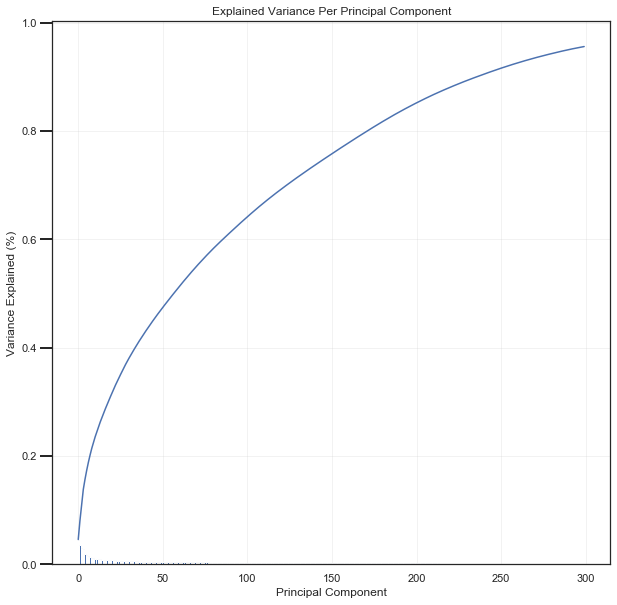

In [127]:
plot_variance(pca)

In [128]:
# we see from the above that roughly 150 of the components explain around 75% of the variance
# also the variance explained does not increase at a high rate with the increase in the number of components beyond 150
# Hence let's now reduce the number of PCA components to 150 and get those components
pca_150, X_pca_150 = do_pca(df_clean_general, 150)

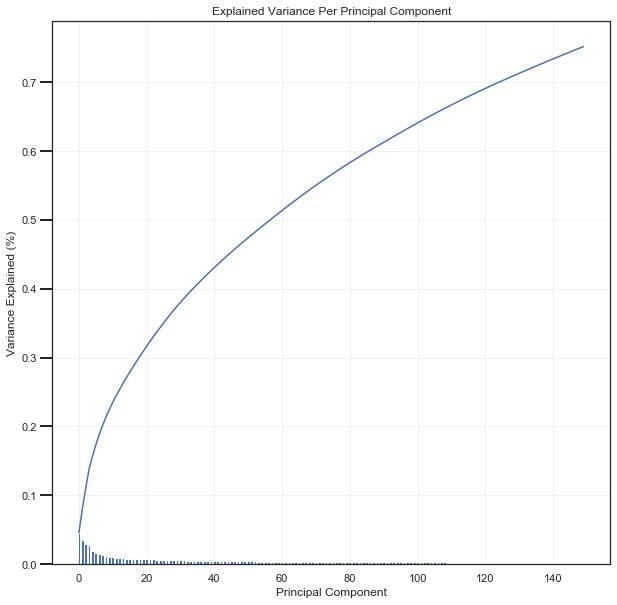

In [129]:
# let's look at the explained variance now to confirm
plot_variance(pca_150)

In [130]:
# now let's look at a few components and map it to the features that contribute the most to those components
pca_150.components_

array([[ 0.03719012,  0.00739603, -0.01012451, ...,  0.01603192,
        -0.04031477, -0.02856301],
       [-0.00856715,  0.0373623 , -0.04914752, ..., -0.04115332,
        -0.01129574,  0.0135979 ],
       [-0.03875915, -0.06075575, -0.01857745, ...,  0.08324719,
         0.04963112,  0.01662974],
       ...,
       [-0.01941291,  0.0027049 , -0.01469718, ..., -0.04112522,
         0.03205307,  0.04240807],
       [ 0.02737577,  0.04895735, -0.00231241, ...,  0.05099331,
        -0.04615237,  0.00803931],
       [ 0.0327824 ,  0.02021361,  0.00219921, ...,  0.00045403,
         0.01393284,  0.05209725]])

In [131]:
component_names = ['comp-{}'.format(i) for i in range(1, len(pca_150.components_)+1)]
df_components = pd.DataFrame(pca_150.components_, columns=df_clean_general.columns, index=component_names)
df_components.head()

,KBA13_KRSSEG_VAN,SEMIO_LUST,KBA05_HERSTTEMP,KBA13_FIAT,KBA13_CCM_1400,KBA05_ALTER2,KBA13_HALTER_65,KBA13_VORB_2,KBA13_NISSAN,KBA13_FAB_SONSTIGE,KBA05_SEG9,KBA05_KW3,KBA13_FAB_ASIEN,KBA13_SEG_SPORTWAGEN,KBA13_CCM_1200,KBA13_SEG_KLEINST,WOHNLAGE,D19_VERSI_ANZ_24,KBA13_KW_70,FINANZ_HAUSBAUER,KBA05_ANTG1,KBA05_SEG5,KBA13_SEG_OBERKLASSE,KBA05_KRSVAN,KBA13_HALTER_30,KBA13_ALTERHALTER_61,KBA13_KW_50,KBA05_CCM2,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,KBA13_KW_121,KBA13_SEG_UTILITIES,KBA13_KRSSEG_KLEIN,SEMIO_KRIT,KBA13_HALTER_25,KBA05_ANTG2,KBA05_KRSHERST2,KBA05_VORB1,KBA13_HERST_FORD_OPEL,KBA13_ALTERHALTER_30,KBA13_FORD,KBA13_KW_0_60,KBA05_ANTG3,KBA13_HALTER_40,KBA13_KMH_250,KBA13_HALTER_66,KBA13_HERST_AUDI_VW,PLZ8_HHZ,SEMIO_TRADV,ALTERSKATEGORIE_GROB,KBA13_BJ_2008,KBA05_MAXAH,KBA13_KMH_140,KBA13_VORB_3,KBA13_CCM_1000,KBA13_BMW,KBA13_KMH_0_140,KBA13_KMH_140_210,KBA13_KW_40,ORTSGR_KLS9,KBA05_VORB2,KBA13_KRSHERST_AUDI_VW,KBA05_KRSZUL,FINANZ_ANLEGER,KBA13_MERCEDES,KBA13_SEG_WOHNMOBILE,KBA13_BJ_2004,ONLINE_AFFINITAET,KBA13_CCM_2000,KBA05_CCM3,WOHNDAUER_2008,KBA13_VORB_1_2,KBA13_HERST_EUROPA,KBA13_BJ_2009,KBA13_KRSSEG_OBER,FINANZ_VORSORGER,KBA13_CCM_0_1400,KBA13_KMH_211,KBA13_KW_60,FINANZ_SPARER,D19_VERSAND_ANZ_24,KBA05_SEG2,KBA13_VORB_1,KBA05_SEG4,KBA13_HALTER_60,KBA13_KRSHERST_FORD_OPEL,KBA05_KW2,KBA05_MOD3,BALLRAUM,KBA13_CCM_2501,KBA13_KRSHERST_BMW_BENZ,KBA13_TOYOTA,KBA05_GBZ,KBA13_HALTER_35,KBA13_SITZE_5,KBA13_HALTER_50,SEMIO_VERT,KBA13_ALTERHALTER_60,KBA13_PEUGEOT,MOBI_REGIO,KBA13_SEG_MINIVANS,KBA13_HERST_SONST,KBA05_KRSHERST3,HH_EINKOMMEN_SCORE,KBA05_HERST2,PLZ8_GBZ,KBA13_SEG_MITTELKLASSE,KBA13_SEG_GROSSRAUMVANS,D19_BANKEN_ANZ_12,KBA05_SEG6,KBA13_SEG_VAN,SEMIO_MAT,EWDICHTE,W_KEIT_KIND_HH,SEMIO_DOM,KBA05_MAXBJ,KBA05_MOD8,KBA13_CCM_1600,KBA13_HERST_ASIEN,D19_VERSI_ANZ_12,SEMIO_SOZ,KBA05_ANHANG,KBA05_KRSHERST1,KBA05_MOD1,KBA13_SITZE_6,KBA13_SEG_KLEINWAGEN,PLZ8_BAUMAX,KBA13_HERST_BMW_BENZ,KBA13_SEG_GELAENDEWAGEN,KBA05_DIESEL,KBA13_KMH_110,KBA13_CCM_2500,KBA05_MOD2,SEMIO_KULT,SEMIO_PFLICHT,FINANZ_MINIMALIST,KBA13_CCM_1800,KBA13_ALTERHALTER_45,KBA13_CCM_3000,SEMIO_FAM,KBA13_KW_110,KBA13_CCM_1500,KBA13_SITZE_4,FINANZ_UNAUFFAELLIGER,SEMIO_ERL,KBA13_VW,KBA05_ZUL4,KBA13_KRSZUL_NEU,KBA05_CCM1,KBA05_ALTER3,KBA13_KW_80,KBA13_KMH_180,KBA13_KW_90,D19_VERSAND_ANZ_12,KBA05_ZUL2,KBA05_ANTG4,KBA05_SEG10,KKK,PLZ8_ANTG4,KBA13_KW_61_120,SEMIO_KAEM,KBA05_KRSOBER,KBA13_BJ_2006,KBA05_ZUL1,KBA13_KRSAQUOT,KBA05_SEG7,KBA05_SEG8,KBA13_AUDI,KBA13_BJ_1999,KBA05_KRSKLEIN,REGIOTYP,KBA13_BJ_2000,KBA05_ALTER1,KBA13_KMH_251,KBA05_MOTRAD,KBA13_SEG_MINIWAGEN,D19_BANKEN_ANZ_24,KONSUMNAEHE,KBA13_VORB_0,KBA05_FRAU,KBA13_MOTOR,KBA13_KW_120,D19_GESAMT_ANZ_24,KBA05_KRSAQUOT,KBA13_HALTER_20,KBA13_HALTER_45,KBA13_CCM_3001,KBA13_KW_30,SEMIO_REL,KBA05_HERST5,KBA05_VORB0,KBA13_HALTER_55,KBA05_ALTER4,KBA05_HERST4,KBA05_AUTOQUOT,KBA13_AUTOQUOTE,KBA05_MOD4,KBA05_KW1,SEMIO_RAT,KBA13_SEG_SONSTIGE,D19_GESAMT_ANZ_12,INNENSTADT,KBA05_SEG1,KBA13_MAZDA,KBA13_SEG_OBEREMITTELKLASSE,KBA05_ZUL3,KBA13_SEG_KOMPAKTKLASSE,RELAT_AB,KBA05_HERST1,KBA05_CCM4,KBA05_SEG3,KBA05_HERST3,KBA13_OPEL,KBA13_RENAULT,ANREDE_KZ_1,ANREDE_KZ_2,CJT_GESAMTTYP_1,CJT_GESAMTTYP_2,CJT_GESAMTTYP_3,CJT_GESAMTTYP_4,CJT_GESAMTTYP_5,CJT_GESAMTTYP_6,D19_BANKEN_DATUM_1,D19_BANKEN_DATUM_2,D19_BANKEN_DATUM_3,D19_BANKEN_DATUM_4,D19_BANKEN_DATUM_5,D19_BANKEN_DATUM_6,D19_BANKEN_DATUM_7,D19_BANKEN_DATUM_8,D19_BANKEN_DATUM_9,D19_BANKEN_DATUM_10,D19_BANKEN_OFFLINE_DATUM_1,D19_BANKEN_OFFLINE_DATUM_2,D19_BANKEN_OFFLINE_DATUM_3,D19_BANKEN_OFFLINE_DATUM_4,D19_BANKEN_OFFLINE_DATUM_5,D19_BANKEN_OFFLINE_DATUM_6,D19_BANKEN_OFFLINE_DATUM_7,D19_BANKEN_OFFLINE_DATUM_8,D19_BANKEN_OFFLINE_DATUM_9,D19_BANKEN_OFFLINE_DATUM_10,D19_BANKEN_ONLINE_DATUM_1,D19_BANKEN_ONLINE_DATUM_2,D19_BANKEN_ONLINE_DATUM_3,D19_BANKEN_ONLINE_DATUM_4,D19_BANKEN_ONLINE_DATUM_5,D19_BANKEN_ONLINE_DATUM_6,D19_BANKEN_ONLINE_DATUM_7,D19_BANKEN_ONLINE_DATUM_8,D19_BANKEN_ONLINE_DATUM_9,D19_BANKEN_ONLINE_DATUM_10,D19_GESAMT_DATUM_1,D19_GESAMT_DATUM_2,D19_GESAMT_DATUM_3,D19_GESAMT_DATUM_4,D

In [132]:
def show_top_n_fetaures(component_n, n_features):
    '''
    component_n: prinicipal component number
    n_features: number of top positive and top negatively contributing features
    '''
    comp_name = 'comp-{}'.format(component_n)
    top_5 = df_components.loc[comp_name].sort_values(ascending=False)[:n_features]
    neg_5 = df_components.loc[comp_name].sort_values(ascending=True)[:n_features]
    
    print('Top 5 features positively corelated to compoenent {} are:'.format(component_n))
    print(top_5)
    
    print('Top 5 features negatively corelated to compoenent {} are:'.format(component_n))
    print(neg_5)

In [133]:
show_top_n_fetaures(1, 5)

Top 5 features positively corelated to compoenent 1 are:
MOBI_REGIO           0.152009
KBA05_ANTG1          0.140146
PLZ8_ANTG1           0.127922
D19_GESAMT_ANZ_24    0.127423
KBA05_GBZ            0.120668
Name: comp-1, dtype: float64
Top 5 features negatively corelated to compoenent 1 are:
PLZ8_ANTG3                    -0.127277
D19_VERSAND_DATUM_10          -0.120996
D19_GESAMT_DATUM_10           -0.120041
D19_GESAMT_ONLINE_DATUM_10    -0.116297
D19_VERSAND_ONLINE_DATUM_10   -0.113857
Name: comp-1, dtype: float64


In [134]:
show_top_n_fetaures(2, 5)

Top 5 features positively corelated to compoenent 2 are:
KBA13_HERST_BMW_BENZ           0.169477
KBA13_SEG_OBEREMITTELKLASSE    0.145901
KBA13_MERCEDES                 0.145264
KBA13_BMW                      0.140851
KBA13_SITZE_4                  0.137719
Name: comp-2, dtype: float64
Top 5 features negatively corelated to compoenent 2 are:
KBA13_SITZE_5          -0.139611
KBA13_KMH_140_210      -0.120460
KBA13_SEG_KLEINWAGEN   -0.119337
KBA13_HALTER_25        -0.112548
OST_WEST_KZ_O          -0.106697
Name: comp-2, dtype: float64


In [135]:
show_top_n_fetaures(3, 5)

Top 5 features positively corelated to compoenent 3 are:
PLZ8_ANTG4           0.156446
PLZ8_BAUMAX          0.144369
ORTSGR_KLS9          0.129524
D19_GESAMT_ANZ_24    0.127319
D19_GESAMT_ANZ_12    0.117335
Name: comp-3, dtype: float64
Top 5 features negatively corelated to compoenent 3 are:
LP_STATUS_FEIN_5             -0.129477
KBA13_AUTOQUOTE              -0.128638
D19_GESAMT_ONLINE_DATUM_10   -0.128470
ZABEOTYP_3                   -0.125456
KBA13_ALTERHALTER_60         -0.123049
Name: comp-3, dtype: float64


In [136]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

In [137]:
from sklearn.cluster import KMeans

def apply_kmeans(data, n):
    '''
    PARAMS:
        data - dataframe that contains the data to cluster
        n - number of clusters required
    RETURN
        Returns the KMeans clustering score
    '''
    kmeans = KMeans(n_clusters=n, random_state=1)
    model = kmeans.fit(data)
    return np.abs(model.score(data))

In [138]:
# try out KMeans with diff. number of clusters
# let's first try till 14 number of clusters to see if we can get an elbow that gives us an optimum
scores = []

for i in range(2,14,2):
    score = round(apply_kmeans(X_pca_150, i),2)
    print('center : {}     score : {}'.format(i, score))
    scores.append(score)

center : 2     score : 288577451.41
center : 4     score : 274297633.67
center : 6     score : 264986193.74
center : 8     score : 259249473.79
center : 10     score : 254816044.9
center : 12     score : 251452624.57


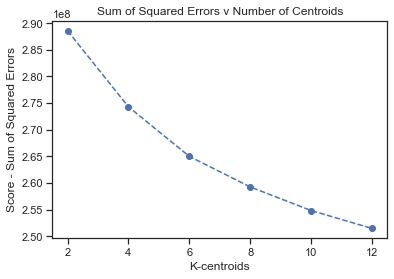

In [139]:
# Let's plot the scores against the number of clusters
plt.plot(range(2,14,2), scores, linestyle='--', marker='o', color='b');
plt.xlabel('K-centroids');
plt.ylabel('Score - Sum of Squared Errors');
plt.title('Sum of Squared Errors v Number of Centroids');

In [140]:
# From the above chart, a slight elbow shape can be seen at 6, hence let's go with 6 clusters

kmeans_6 = KMeans(n_clusters=6, random_state=1)

# Then fit the model to your data using the fit method
model_general = kmeans_6.fit(X_pca_150)

# Finally predict the labels or clusters on the same data using the predict method 
predict_general_clusters = model_general.predict(X_pca_150)

In [141]:
predict_general_clusters

array([1, 4, 0, ..., 5, 4, 3], dtype=int32)

In [142]:
# look at the cluster number that the first few 

In [143]:
pd.Series(predict_general_clusters).value_counts().sort_values()

1     77321
2    109247
0    115952
5    159511
4    212426
3    216764
dtype: int64

In [144]:
# Now let's perform clustering on the customer data

In [145]:
df_customers = df_customers[df_clean_general.columns]

In [146]:
# performm PCA on the customer data
customers_pca = pca_150.transform(df_customers)

In [147]:
customers_clusters = kmeans_6.predict(customers_pca)

In [148]:
customers_clusters

array([0, 3, 0, ..., 3, 3, 5], dtype=int32)

In [149]:
pd.Series(customers_clusters).value_counts().sort_values()

2     6016
4    12111
5    35125
0    45558
3    46189
1    46653
dtype: int64

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [4]:
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

/Users/nareshsharma/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
print(mailout_train.shape)
print((mailout_train.RESPONSE.sum())*100/len(mailout_train))

(42962, 367)
1.2383036171500397


# Observations on data

1. The percentage of folks who actually become a customer is very less... hence we need a way to score with a higher recall

In [6]:
def plot_hist_missing_col(df):
    '''
    INPUT:
        df - (dataframe), dataframe to check for missing data and plot histogram of the missing data in columns
    OUTPUT:
        visualization: (histogram), of the missing data
    '''
    plt.hist(df['pct'], bins=20, facecolor='g', alpha=0.75)

    plt.xlabel('Percentage of missing value (%)', fontsize=12)
    plt.ylabel('Counts', fontsize=12)
    plt.title('Histogram of missing value counts in columns', fontsize=12)
    plt.grid(True)
    plt.show()


def get_null_counts(df):
    null_data = df.isnull().sum()[df.isnull().sum() > 0]
    dict = {'nulls': null_data.values, 'pct': np.round(null_data.values*100/df.shape[0], 2)}
    df_nulls = pd.DataFrame(data=dict, index=null_data.index)
    return df_nulls

0


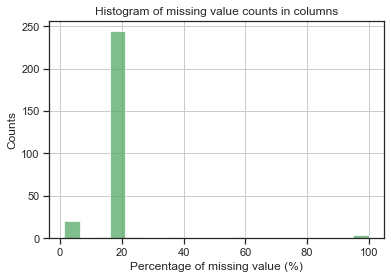

,nulls,pct
ALTER_KIND4,42921,99.90
ALTER_KIND3,42788,99.59
ALTER_KIND2,42206,98.24
ALTER_KIND1,40974,95.37
KK_KUNDENTYP,25316,58.93
EXTSEL992,15948,37.12
W_KEIT_KIND_HH,9678,22.53
HH_DELTA_FLAG,9678,22.53
KBA05_ZUL1,8648,20.13
KBA05_KRSZUL,8648,20.13


In [7]:
print(mailout_train.RESPONSE.isnull().sum())
mailout_nulls = get_null_counts(mailout_train)
plot_hist_missing_col(mailout_nulls)
mailout_nulls.sort_values(by=['pct'], axis=0, kind='quicksort', ascending=False)
# mailout_nulls

In [85]:
print(len(set(azdias_sel_cols.columns).intersection(set(mailout_train.columns))))
print(set(azdias_sel_cols.columns) - set(mailout_train.columns))

265
set()


In [86]:
# Observations
# The columns that have a large number of nulls pretty much match the columns of general population, having large number of nulls
# Also all the columns that were used for clustering are available in the mailout dataset... so we should be able to apply the same cleanup process to this dataset
mailout_train.head()


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [87]:
# First separate the datset into responses and their equivalent features
df_responses = mailout_train.RESPONSE
# df_features = mailout_train.drop(columns=['RESPONSE'])

In [88]:
final_column_list

Index(['KBA13_KW_90', 'INNENSTADT', 'KBA05_VORB1', 'KBA13_HERST_BMW_BENZ',
       'KBA13_BJ_2009', 'KBA13_KW_110', 'GEBURTSJAHR', 'KBA05_ALTER2',
       'KBA05_ZUL1', 'D19_TELKO_OFFLINE_DATUM',
       ...
       'KBA05_ALTER4', 'KBA05_MOTRAD', 'KBA13_CCM_2500', 'KBA13_SEG_UTILITIES',
       'KBA13_HALTER_45', 'KBA13_PEUGEOT', 'KBA13_NISSAN', 'KBA13_KMH_110',
       'PLZ8_ANTG1', 'ANZ_HAUSHALTE_AKTIV'],
      dtype='object', length=265)

Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Category
D19_TELKO_OFFLINE_DATUM
valid values for column:D19_TELKO_OFFLINE_DATUM, are [1 2 3 4 5 6 7 8 9 10]
42962
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Category
KBA05_MAXSEG
valid values for column:KBA05_MAXSEG, are [1 2 3 4]
33931
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Category
D19_VERSAND_ONLINE_DATUM
valid values for column:D19_VERSAND_ONLINE_DATUM, are [1 2 3 4 5 6 7 8 9 10]
42962
Numerical
Numerical
Numerical
Category
D19_TELKO_DATUM
valid values for column:D19_TELKO_DATUM, are [1 2 3 4 5 6 7 8 9 10]
42962
Numerical
Category
KBA05_MAXHERST
valid values for column:KBA05_MAXHERST, are [1 2 3 4 5]
33931
Numerical
Category
SHOPPER_TYP
valid values for column:SHOPPER_TYP, are [0 1 2 3]
35565
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numerical
Numer

In [94]:
print(mailout_train_cleaned.shape)
print(mailout_train.shape)
print(mailout_train[object_type_columns].isnull().sum())

(35063, 581)
(42962, 367)
OST_WEST_KZ       7777
CAMEO_DEU_2015    7899
dtype: int64


In [95]:
mailout_train_cleaned.isnull().sum()

KBA13_KW_90                     0
INNENSTADT                      0
KBA05_VORB1                     0
KBA13_HERST_BMW_BENZ            0
KBA13_BJ_2009                   0
KBA13_KW_110                    0
GEBURTSJAHR                     0
KBA05_ALTER2                    0
KBA05_ZUL1                      0
KBA13_TOYOTA                    0
KBA05_ALTER1                    0
D19_GESAMT_ANZ_12               0
KBA13_KRSZUL_NEU                0
KBA13_HERST_FORD_OPEL           0
KBA05_HERST4                    0
KBA05_SEG2                      0
KBA13_KMH_0_140                 0
KBA13_VORB_1                    0
FINANZ_SPARER                   0
KBA05_FRAU                      0
KBA13_BJ_2004                   0
PLZ8_BAUMAX                     0
KBA13_HALTER_66                 0
KBA13_MERCEDES                  0
KBA13_KRSAQUOT                  0
KBA05_KRSZUL                    0
KBA13_KMH_251                   0
KBA13_KW_121                    0
KBA13_SEG_KLEINWAGEN            0
KBA13_SEG_GELA

In [96]:
# Let's split the data into train and test data for our model buidling purposes
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(df_features_cleaned, df_responses, test_size=0.33, random_state=40)

In [97]:
df_features = mailout_train_cleaned.drop(columns=['RESPONSE'])
df_responses = mailout_train_cleaned.RESPONSE
# df_responses.astype('int').head()
df_responses.isnull().sum()

0

In [182]:
print(object_type_columns)
print(categorical_dict['CAMEO_DEU_2015'])
mailout_train[object_type_columns[0]].append(mailout_train[object_type_columns[1]]).unique()

['OST_WEST_KZ', 'CAMEO_DEU_2015']
[1A, 1B, 1C, 1D, 1E, ..., 9A, 9B, 9C, 9D, 9E]
Length: 44
Categories (44, object): [1A, 1B, 1C, 1D, ..., 9B, 9C, 9D, 9E]


array(['W', 'O', nan, '5D', '5B', '2D', '7B', '4C', '5C', '3D', '5A',
       '2C', '4A', '6B', '1A', '8D', '4B', '7A', '4E', '3A', '7C', '9D',
       '8A', '5E', '8B', '3C', '6E', '4D', '2B', '3B', '7E', '2A', '6C',
       '1C', '6D', '7D', '1D', '8C', '9A', '9B', '9C', '9E', '6F', '1E',
       '6A', '5F', '1B'], dtype=object)

In [154]:
df_features.shape

(35063, 580)

In [172]:
print(object_type_columns)
print(mailout_train[(mailout_train.CAMEO_DEU_2015.isnull()) & (mailout_train.OST_WEST_KZ.isnull())].RESPONSE.sum())


print(mailout_train.RESPONSE.sum())
print(df_responses.sum())

['OST_WEST_KZ', 'CAMEO_DEU_2015']
93
532
438


In [131]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV   #Perforing grid search

parameters = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse"],
    "subsample":[0.5, 0.8, 1.0],
    "n_estimators":[10]
    }

0.6780533109143959
{'criterion': 'friedman_mse', 'learning_rate': 0.025, 'loss': 'deviance', 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'subsample': 0.8}


In [ ]:
clf = GridSearchCV(GradientBoostingClassifier(), parameters, cv=5, n_jobs=-1, scoring='roc_auc',)

clf.fit(df_features, df_responses)

In [148]:
print(clf.best_score_)
print(clf.best_params_)

0.5656942362990837
{'criterion': 'friedman_mse', 'learning_rate': 0.025, 'loss': 'deviance', 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'subsample': 0.8}


In [151]:
parameters = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
#     "max_features":["log2","sqrt"],
    "subsample":[0.5, 0.8, 1.0],
    "n_estimators":[10]
    }

clf2 = GridSearchCV(GradientBoostingClassifier(), parameters, cv=5, scoring='f1',)
clf2.fit(df_features, df_responses)
print(clf2.best_score_)
print(clf2.best_params_)
# clf2.fit(df_features, df_responses)


0.0
{'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 0.1, 'min_samples_split': 0.1, 'n_estimators': 10, 'subsample': 0.5}


In [153]:
print(clf2.score(df_features, df_responses))
print(clf2.best_params_)

0.0
{'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 0.1, 'min_samples_split': 0.1, 'n_estimators': 10, 'subsample': 0.5}


In [137]:
print(clf.score(df_features, df_responses))
print(clf.best_params_)

0.6780533109143959
{'criterion': 'friedman_mse', 'learning_rate': 0.025, 'loss': 'deviance', 'max_depth': 3, 'max_features': 'log2', 'min_samples_leaf': 0.1, 'min_samples_split': 0.13636363636363638, 'subsample': 0.8}


In [145]:
print(df_responses[df_responses==1].head())
# predictions = clf.predict(df_features.iloc[[78,107,141,167,203]])
predictions = clf2.predict(df_features)
# df_features.iloc[[78,107]]
print('Number of predictions with possitive responses: {}'.format(np.sum(predictions)))
print('Number of possitive responses: {}'.format(np.sum(df_responses.sum())))
print(mailout_train.RESPONSE.sum())

78     1
107    1
141    1
167    1
203    1
Name: RESPONSE, dtype: int64
Number of predictions with possitive responses: 33
Number of possitive responses: 438
532


In [138]:
# predictions = clf.predict(df_features.iloc[[78,107,141,167,203]])
predictions1 = clf.predict(df_features)
# df_features.iloc[[78,107]]
print('Number of predictions with possitive responses: {}'.format(np.sum(predictions1)))
print('Number of predictions with possitive responses: {}'.format(np.sum(df_responses.sum())))

Number of predictions with possitive responses: 0
Number of predictions with possitive responses: 438


## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
# mailout_test = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_MAILOUT_052018_TEST.csv', sep=';')